# Impact of Maternal COVID-19 Concerns on Pregnancy Outcomes

<p align="center"><b> Hanjian Xu</b></p>
<p align="center">June 23, 2024</p>

---


This project explores the impact of maternal concerns about COVID-19 on prenatal mental health and pregnancy outcomes using data from Canadian annual birth estimates and a Canadian survey on pregnancy during the COVID-19 pandemic (2020-2021).


## Overview
**Section 1: Canada Birth Data Trend Analysis**

This section examines the annual birth estimates in Canada from 1971 to 2023. The analysis focuses on identifying trends and anomalies in birth estimates over time, with particular attention to the changes that occurred after the breakout of the COVID-19 pandemic.

**Section 2: COVID-19 Related Mental Health and Birth Outcomes Analysis**

With a more focused time window, this section explores the impact of maternal concerns related to COVID-19 on various pregnancy outcomes from a published dataset of a research survey conducted from 2020 to 2021. The analysis assesses how concerns about COVID-19 relate to maternal mental health, specifically anxiety and depression, and how they affect birth outcomes such as gestational age, birth weight, and birth length.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Prepare libraries/modules needed
!pip install factor_analyzer > /dev/null 2>&1
!pip install pingouin > /dev/null 2>&1
!pip install semopy > /dev/null 2>&1
!pip install pmdarima > /dev/null 2>&1
!pip install python-dotenv > /dev/null 2>&1

import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf

from factor_analyzer import FactorAnalyzer
from pingouin import cronbach_alpha
import semopy
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")

%cd '/content/drive/MyDrive/can_pregnancy_covid'


/content/drive/MyDrive/pregnancy_project/can_pregnancy_covid


# Data Preparation

### Two datasets for analysis:

#### 1. **Annual Estimates of Birth (by gender) in Canada**

Data obtained from `https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710001601`
- **Table Number**: 17100016-eng.csv
- **Content**:
  - Details the annual birth estimates from 1971/1972 to 2022/2023.
  - Segmented by gender and geographic regions.

#### 2. **Pregnancy during the pandemic (PdP) data**
Data obtained from `https://doi.org/10.1016/j.dib.2023.109366`
- **Content**:
  - Demographics
    - Maternal Age: Age at intake
    - Household Income: Total household income in 2019
    - Maternal Education: Education level
    - Language: Survey language (EN/FR)
  - Depression/Anxiety Assessment
    - Edinburgh Postnatal Depression Scale: Antenatal depression measure (ranged 0-30)
    - PROMIS Anxiety: Antenatal anxiety measure (ranged 7-35)
  - COVID-19 Fear
    - Threaten Life: Perceived danger to life during the COVID-19 pandemic (0-100)
    - Threaten Baby Danger: Perceived danger to unborn baby's life during the COVID-19 pandemic (0-100)
    - Threaten Baby Harm: Concern about COVID-19 exposure harming the unborn baby (0-100)
  - Birth Outcomes
    - Gestational Age at Birth (weeks)
    - Delivery Date: Month and year of delivery
    - Birth Length (cm)
    - Birth Weight (g)
    - Delivery Mode: Vaginal or C-section
    - NICU Stay: Yes/No


In [4]:
# Set the style for the matploftlib library
plt.style.use('ggplot')
height = 6
aspect = 8 / height

##1. Load PdP Data

In [5]:
# Load the PdP data
df = pd.read_csv(os.getcwd() + '/data/OSFData_Upload_2023_Mar30.csv')
df.head(5)
print(df.shape)
# 31455 cells are null.
print(df.isnull().sum().sum())

(10772, 16)
31455


In [6]:
# Replace whitespace with nan
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10772 entries, 0 to 10771
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   OSF_ID                                      10772 non-null  int64  
 1   Maternal_Age                                10661 non-null  float64
 2   Household_Income                            10521 non-null  object 
 3   Maternal_Education                          10595 non-null  object 
 4   Edinburgh_Postnatal_Depression_Scale        9598 non-null   float64
 5   PROMIS_Anxiety                              9566 non-null   float64
 6   Gestational_Age_At_Birth                    6734 non-null   float64
 7   Delivery_Date(converted to month and year)  6733 non-null   object 
 8   Birth_Length                                5480 non-null   float64
 9   Birth_Weight                                6078 non-null   float64
 10  Delivery_M

## 2. Load Canada Annual Birth Estimates Data

In [7]:
# Load the dataset
birth_path = os.getcwd() + '/data/annual_birth_can.csv'
birth_data = pd.read_csv(birth_path)

# Remove unused data
birth_data = birth_data[["REF_DATE", "GEO", "Gender", "VALUE", "TERMINATED"]]

# Inspect the data
print(birth_data.head())
print(birth_data.shape)
birth_data.info()

    REF_DATE                        GEO          Gender   VALUE TERMINATED
0  1971/1972                     Canada  Total - gender  351256        NaN
1  1971/1972                     Canada            Men+  181106        NaN
2  1971/1972                     Canada          Women+  170150        NaN
3  1971/1972  Newfoundland and Labrador  Total - gender   12746        NaN
4  1971/1972  Newfoundland and Labrador            Men+    6591        NaN
(2124, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124 entries, 0 to 2123
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   REF_DATE    2124 non-null   object
 1   GEO         2124 non-null   object
 2   Gender      2124 non-null   object
 3   VALUE       2124 non-null   int64 
 4   TERMINATED  60 non-null     object
dtypes: int64(1), object(4)
memory usage: 83.1+ KB


# Section 1 - Canada Birth Data Trend Analysis

## Data Cleaning

Rename column names for easier use.

In [8]:
# Clean up the df
## Use the first year of 'REF_DATE' column and to int type
birth_data['REF_DATE'] = birth_data['REF_DATE'].apply(lambda x: int(x.split('/')[0])).astype(int)
birth_data.dtypes

# time manipulation (+/- 1 year)
# birth_data['REF_DATE'] + pd.DateOffset(years=1)

## Rename the Gender column values
gender_mapping = {
    'Total - gender': 'Total',
    'Men+': 'Men',
    'Women+': 'Women'
}

birth_data['Gender'] = birth_data['Gender'].replace(gender_mapping)

## Rename columns:
birth_data.rename(columns={'GEO': 'geo', 'Gender': 'gender', 'REF_DATE': 'year', 'VALUE': 'birth_count', 'TERMINATED': 'terminated'}, inplace=True)

## Filter for Canada as a whole
canada_data = birth_data[birth_data['geo'] == 'Canada']
canada_data = canada_data.drop(columns=['terminated'])

# Filter data for total births in Canada
# canada_total = birth_data[(birth_data['geo'] == 'Canada') & (birth_data['gender'] == 'Total')]

In [9]:
# data for Northwest Territories and Nunavut territories were separated after 1990. For simplicity, collapsing them after:
nwdata = birth_data[(birth_data['geo'].isin(['Northwest Territories', 'Nunavut'])) & (birth_data['year'] >= 1991)]

# Group and sum the birth counts by year and gender
nwdata_combined = nwdata.groupby(['year', 'gender']).agg({'birth_count': 'sum'}).reset_index()
nwdata_combined['geo'] = 'Northwest Territories including Nunavut'

# Drop the original 'Northwest Territories' and 'Nunavut' rows after 1990
birth_data = birth_data[~((birth_data['geo'].isin(['Northwest Territories', 'Nunavut'])) & (birth_data['year'] >= 1991))]

# Concatenate the new combined data with the original DataFrame
nwdata_combined = nwdata_combined[['year', 'geo', 'gender', 'birth_count']]
birth_data = pd.concat([birth_data, nwdata_combined], ignore_index=True)
birth_data.groupby(by=['geo', 'gender']).count()
birth_data.shape

(2028, 5)

## Data Visualization & Exploration

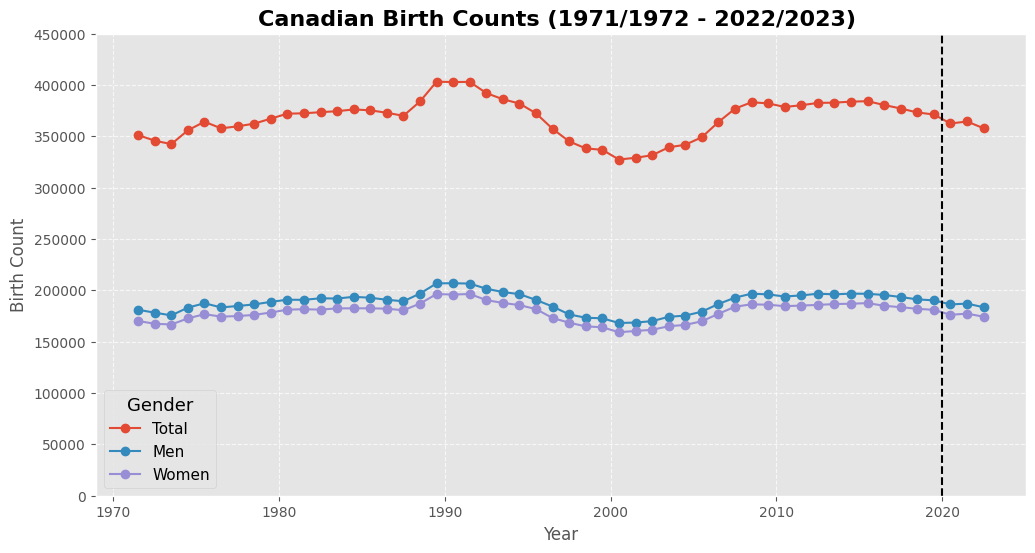

In [10]:
canada_total = canada_data[canada_data['gender'] == 'Total']
canada_men = canada_data[canada_data['gender'] == 'Men']
canada_women = canada_data[canada_data['gender'] == 'Women']

# Plot Canada_total data
plt.figure(figsize=(12, 6))
plt.plot(canada_total['year']+0.5, canada_total['birth_count'], label='Total', marker = 'o')
plt.plot(canada_men['year']+0.5, canada_men['birth_count'], label='Men', marker = 'o')
plt.plot(canada_women['year']+0.5, canada_women['birth_count'], label='Women', marker = 'o')
plt.axvline(x=2020, color='black', linestyle='--')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Birth Count')
plt.ylim(0, 450000)
plt.title('Canadian Birth Counts (1971/1972 - 2022/2023) ', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Gender', title_fontsize='13', fontsize='11', loc = 'lower left')

# Plot it
plt.show()

In [ ]:
# Exploration plot: dynamic dashboard of the same year-count plot by territories
!pip install dash jupyter-dash plotly pyngrok > /dev/null 2>&1
from jupyter_dash import JupyterDash
import plotly.graph_objects as go
from dash import dcc, html
from dash.dependencies import Input, Output
from pyngrok import ngrok
from dotenv import load_dotenv

# Access the tokens
load_dotenv()
my_ngrok_token = os.getenv('my_ngrok_token')

!ngrok authtoken {my_ngrok_token}
# Dataset:
territory_data = birth_data[birth_data['geo'] != 'Canada']
territory_data = territory_data.drop(columns=['terminated'])

# Initialize the JupyterDash app
app = JupyterDash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Canadian Birth Counts by Territory"),
    dcc.Dropdown(
        id='territory-dropdown',
        options=[{'label': terri, 'value': terri} for terri in territory_data['geo'].unique()],
        value='Ontario',  # Default value
        clearable=False
    ),
    dcc.Graph(id='birth-count-plot')
])

# Callback to update the graph based on selected province
@app.callback(
    Output('birth-count-plot', 'figure'),
    [Input('territory-dropdown', 'value')]
)
def update_figure(selected_province):
    filtered_df = territory_data[territory_data['geo'] == selected_province]

    filtered_total = territory_data[(territory_data['geo'] == selected_province) & (territory_data['gender'] == 'Total')]
    filtered_men = territory_data[(territory_data['geo'] == selected_province) & (territory_data['gender'] == 'Men')]
    filtered_women = territory_data[(territory_data['geo'] == selected_province) & (territory_data['gender'] == 'Women')]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=filtered_total['year'] + 0.5, y=filtered_total['birth_count'],
                             mode='lines+markers', name='Total', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=filtered_men['year'] + 0.5, y=filtered_men['birth_count'],
                             mode='lines+markers', name='Men', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=filtered_women['year'] + 0.5, y=filtered_women['birth_count'],
                             mode='lines+markers', name='Women', line=dict(color='purple')))
    fig.add_vline(x=2020, line=dict(color='black', dash='dash'))

    # Update layout to match Matplotlib style
    fig.update_layout(
        title=f'Birth Estimates in {selected_province} (1971/1972 - 2022/2023)',
        xaxis_title='Year',
        yaxis_title='Birth Count',
        legend_title='Gender'
    )
    # fig = px.line(filtered_df, x='year', y='birth_count', color='gender', title=f'Birth Counts in {selected_province}')

    return fig

# Set up ngrok to tunnel the Dash app
port = 8000
public_url = ngrok.connect(port)
print(f'Public URL: {public_url}')

# Run the app
app.run_server(mode='external', port=port)


In [14]:
# stop the ngrok server
ngrok.kill()

Pearson's correlation coefficient: 1.00
p-value: 0.0000


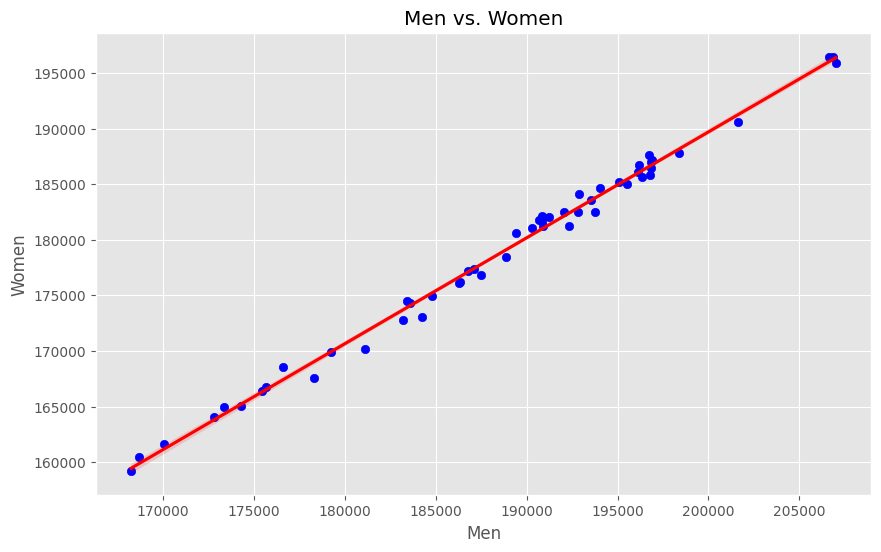

In [17]:
# simple Pearson's correlation between male vs. female counts per year // highly correlated.
r, p = stats.pearsonr(canada_men['birth_count'], canada_women['birth_count'])
print(f"Pearson's correlation coefficient: {r:.2f}\np-value: {p:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(x = canada_men['birth_count'],  y = canada_women['birth_count'], marker = 'o', color = 'blue')
# add trend lm
sns.regplot(x = canada_men['birth_count'],  y = canada_women['birth_count'], scatter=False, color='red', ci=95)
plt.xlabel('Men')
plt.ylabel('Women')
plt.title('Men vs. Women')
plt.show()

Overall, the birth count overall does not display significant seasonal trends.

Next, only the total new births are considered and analyzed with an **autoregressive integrated moving average** (ARIMA) model with early data (up to Year 2019/2020) to forecast data since the pandemic started (from 2020 onwards). I chose the `pmdarima` module to automatically determine the best model parameters.

## Trend Analysis

In [18]:
# Train the ARIMA model using data up to 2019 (pmdarima)
canada_total_ts = canada_total.set_index('year')['birth_count']
train_data = canada_total_ts[canada_total_ts.index <= 2019]
train_data.values

# Automatically determine the best parameters
# V1: full automation:
model = pm.auto_arima(train_data, start_p=0, start_q=0, max_p=5, max_q=5, d = None, seasonal=False, trace=True)

# the ideal model is with order = (2,0,0)

# V2: determine d, p, q
# 1. Determine d:
# from statsmodels.tsa.stattools import adfuller
# Perform ADF test
# result = adfuller(train_data)
# print('ADF Statistic:', result[0])
# print('p-value:', result[1])

# 2. Determine q and p
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ACF and PACF plots (find the first lag that falls within the CIs)
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# plot_acf(train_data, lags=40, ax=axes[0]) # q = 3
# plot_pacf(train_data, lags=24, ax=axes[1]) # p = 4
# plt.show()

# Fit the ARIMA model
model = ARIMA(train_data, order=(2, 0, 0))
model_fit = model.fit()
fitted_data = model_fit.fittedvalues
rmse = np.sqrt(mean_squared_error(train_data.values[1:], fitted_data.values[1:]))
print(f"RMSE: {rmse}")

# model = ARIMA(train_data, order = (5,1,0))
# model_fit = model.fit()
# model_fit.summary()
# predicted_data = model_fit.fittedvalues
# rmse = np.sqrt(mean_squared_error(train_data, predicted_data))
# print(f"RMSE: {rmse}")

# Forecast for 2020 onwards
forecast_years = np.arange(2020, 2023)
forecast = model_fit.forecast(steps=len(forecast_years))
forecast_result = model_fit.get_forecast(steps=len(forecast_years))
conf_int95 = forecast_result.conf_int(alpha = 0.05)
conf_int95['year'] = forecast_years
conf_int95.set_index('year', inplace = True)

conf_int80 = forecast_result.conf_int(alpha = 0.20)
conf_int80['year'] = forecast_years
conf_int80.set_index('year', inplace = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1397.066, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1365.781, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1004.455, Time=0.61 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.42 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1005.039, Time=1.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1360.158, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1007.336, Time=0.63 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=997.684, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1058.020, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1013.008, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=994.812, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=992.746, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=994.742, 

Visualization of the predicted value on top of the actual values.

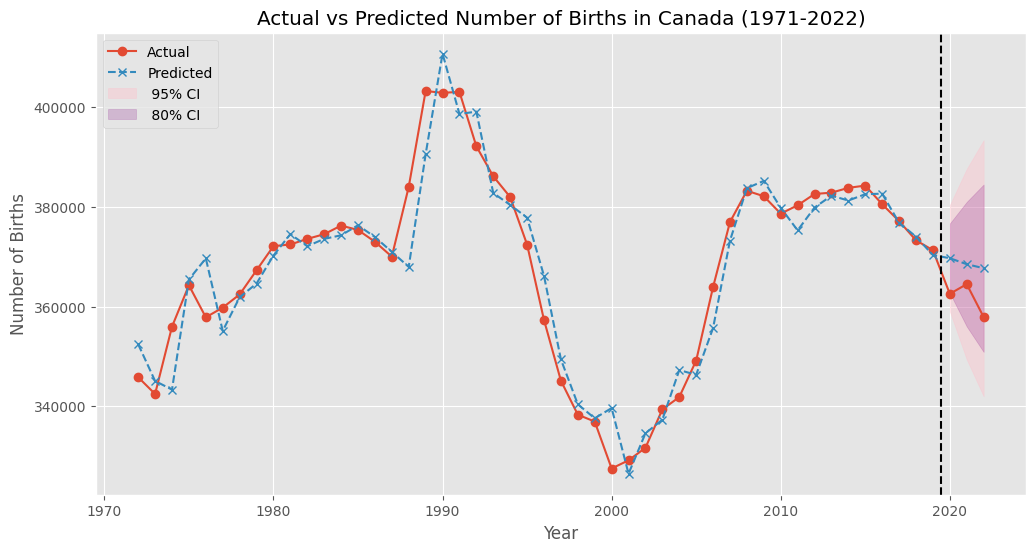

In [19]:
# Ensure the actual data for 2020-2022 is available
actual_values = canada_total_ts[canada_total_ts.index >= 2020]

# Create a DataFrame to compare actual vs predicted values
forecast_df = pd.DataFrame({
    'Year': np.arange(1972, 2023),
    'Predicted': np.concatenate((fitted_data.values[1:],forecast.values)),
    'Actual': canada_total_ts.values[1:]
})

forecast_df.set_index('Year', inplace=True)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['Actual'], label='Actual', marker='o')
plt.plot(forecast_df.index, forecast_df['Predicted'], label='Predicted', marker='x', linestyle='--')
plt.fill_between(conf_int95.index, conf_int95['lower birth_count'], conf_int95['upper birth_count'], color='pink', alpha=0.4, label=' 95% CI')
plt.fill_between(conf_int80.index, conf_int80['lower birth_count'], conf_int80['upper birth_count'], color='purple', alpha=0.2, label=' 80% CI')

plt.axvline(x=2019.5, color='black', linestyle='--')

plt.title('Actual vs Predicted Number of Births in Canada (1971-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Births')
plt.grid(True)
plt.legend()
plt.show()


Although the actual birth counts for the years 2020/2021 to 2022/2023 still fall within the 95% confidence interval of the ARIMA model's forecast, the data point for 2020/2021 is notably right below the lower boundary of the 80% CI. This suggests a somewhat abnormal decrease in the new-born number in Canada during the 2020/2021 cycle, potentially linked to the onset of the COVID-19 pandemic.

Therefore, the subsequent analyses focus on the data collected from a survey study conducted between 2020 and 2021, aiming to further understand the impact of maternal mental health, specifically fear of COVID-19, on birth outcomes.

# Section 2 - COVID-19 Related Mental Health and Birth Outcomes

## Data Cleaning

Ensure correct data types and rename columns for easier use.

In [20]:
# Data format adjustment (dtype)
## data type of last 3 columns
columns_to_convert = ['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm']
# Convert the specified columns to the Int64 data type
df[columns_to_convert] = df[columns_to_convert].astype('float64')

## Rename Deliverty Date column names
df = df.rename(columns={df.columns.tolist()[7]: 'Delivery_Date'})
df = df.rename(columns={df.columns.tolist()[4]: 'EPDS'})

# Convert the delivery date to datetime
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'], format='%b%Y')
str(df.dtypes['Delivery_Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10772 entries, 0 to 10771
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   OSF_ID                    10772 non-null  int64         
 1   Maternal_Age              10661 non-null  float64       
 2   Household_Income          10521 non-null  object        
 3   Maternal_Education        10595 non-null  object        
 4   EPDS                      9598 non-null   float64       
 5   PROMIS_Anxiety            9566 non-null   float64       
 6   Gestational_Age_At_Birth  6734 non-null   float64       
 7   Delivery_Date             6733 non-null   datetime64[ns]
 8   Birth_Length              5480 non-null   float64       
 9   Birth_Weight              6078 non-null   float64       
 10  Delivery_Mode             5537 non-null   object        
 11  NICU_Stay                 5534 non-null   object        
 12  Language          

Checking missing cells.

In [21]:
# check how many datapoints are missing
missing_counts = df.isnull().sum(axis=1) # per row
missing_counts.describe()

count    10772.000000
mean         3.169978
std          3.407651
min          0.000000
25%          0.000000
50%          3.000000
75%          6.000000
max         14.000000
dtype: float64

Clean and rename the income column and its levels:

In [22]:
# Check missing values in the 'Household_Income' column
df['Household_Income'].isna().sum()

# Check the unique values in the 'Household_Income' column before filling the missing values
df['Household_Income'].unique()

# Fill the missing values with 'Unknown'
df['Household_Income'] = df['Household_Income'].fillna('Unknown')

df.loc[df['Household_Income'].str.startswith('$'), 'Household_Income'] = df['Household_Income'].str.replace(' ', '', regex=True)
df.loc[df['Household_Income'].str.startswith('Less'), 'Household_Income'] = 'Less than $20,000'
# Create a dictionary to map the 'Household_Income' column to numerical values
income_to_level = {
    'Unknown': 0,
    'Less than $20,000': 1,
    '$20,000-$39,999': 2,
    '$40,000-$69,999': 3,
    '$70,000-$99,999': 4,
    '$100,000-$124,999': 5,
    '$125,000-$149,999': 6,
    '$150,000-$174,999': 7,
    '$175,000-$199,999': 8,
    '$200,000+': 9,
}

# Check the unique values in the 'Household_Income' column after filling the missing values
df["Household_Income"].unique()

level_to_income = {v: k for k, v in income_to_level.items()}

df['Household_Income'] = df['Household_Income'].replace(income_to_level).astype(int)
df['Household_Income'].head()

0    9
1    9
2    5
3    5
4    3
Name: Household_Income, dtype: int64

In [23]:
# Check missing values in the 'Maternal_Education' column
df['Maternal_Education'].isna().sum()

# Check the unique values in the 'Maternal_Education' column
df['Maternal_Education'].unique()

# Fill the missing values with 'Unknown'
df['Maternal_Education'] = df['Maternal_Education'].fillna('Unknown')

In [24]:
# remove rows with 10+ missing data and exclude rows missing 3 COVID-fear columns (shape: 9844, 16)
# saved as df1 for Goal1: fear <->:
df1 = df[missing_counts <= 10]
df1 = df1.dropna(subset = df1.columns[-3:].tolist())
df1.shape

(9844, 16)

## Exploratory Data Analysis

1. Inspect participant demographatics (language, age, income, etc)
2. Inspect fear and anxiety related scales.
3. Inspect birthoutcome overall information.

#### 1. Demographic Info

*Age & Language:*

Plot the histogram of maternal age, and a barplot of survey language.

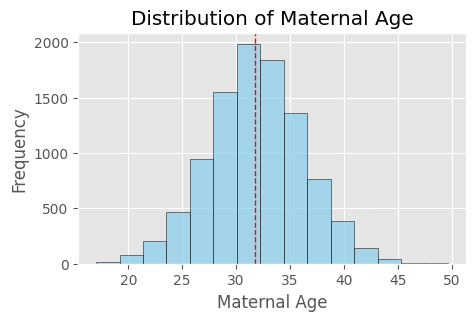

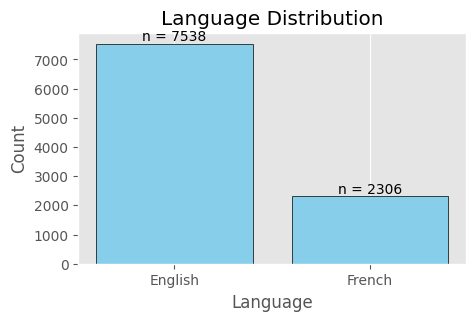

In [25]:
# Histogram for Maternal Age
median_age = df1['Maternal_Age'].median()
mean_age = df1['Maternal_Age'].mean()

plt.figure(figsize=(5, 3))
plt.hist(df1['Maternal_Age'], bins=15, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(median_age, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median_age:.2f}')
# plt.axvline(mean_age, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean_age:.2f}')
plt.title('Distribution of Maternal Age')
plt.xlabel('Maternal Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Bar Plot for Language Distribution
plt.figure(figsize=(5, 3))
bars = plt.bar(df1['Language'].value_counts().index, df1['Language'].value_counts().values, color='skyblue', edgecolor='k')
# n per language group
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'n = {height}', ha='center', va='bottom')

plt.title('Language Distribution')
plt.xlabel('Language')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

*Household_Income:*

Plot the pie chart (percentage) of household income composition in the surveyed participants.


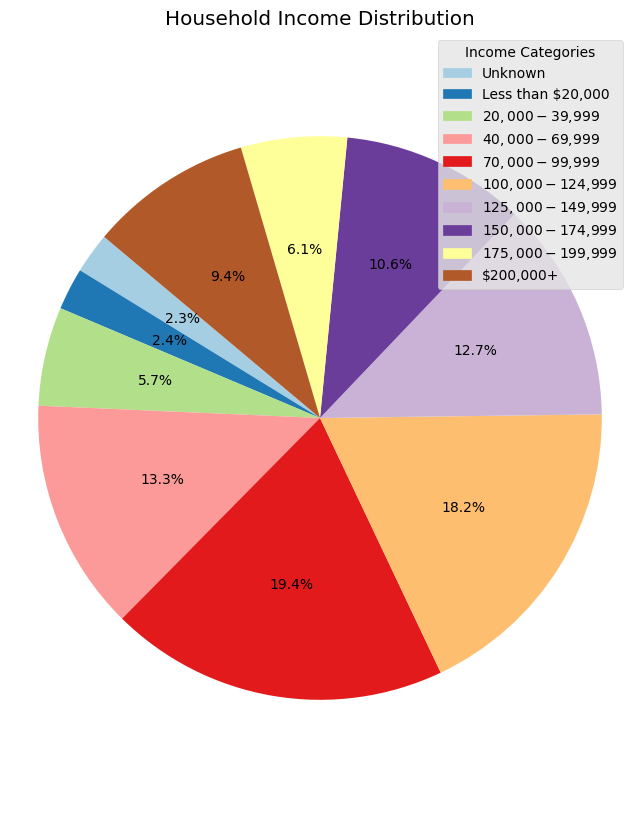

In [26]:
colors = plt.cm.Paired(np.linspace(0, 1, len(level_to_income)))
income_counts = df['Household_Income'].value_counts().sort_index(ascending = True)
patches = [mpatches.Patch(color=colors[index], label=level_to_income[category]) for index, category in enumerate(income_counts.index)]
plt.figure(figsize=(8, 10))
plt.pie(
    income_counts.values,
    autopct='%1.1f%%', startangle=140, shadow=False, colors=colors)
plt.title('Household Income Distribution')
plt.legend(handles=patches, title='Income Categories', loc='upper right')
plt.axis('equal')
plt.show()

*Highest Education:*

Plot the pie chart (percentage) of highest education level in the surveyed participants.

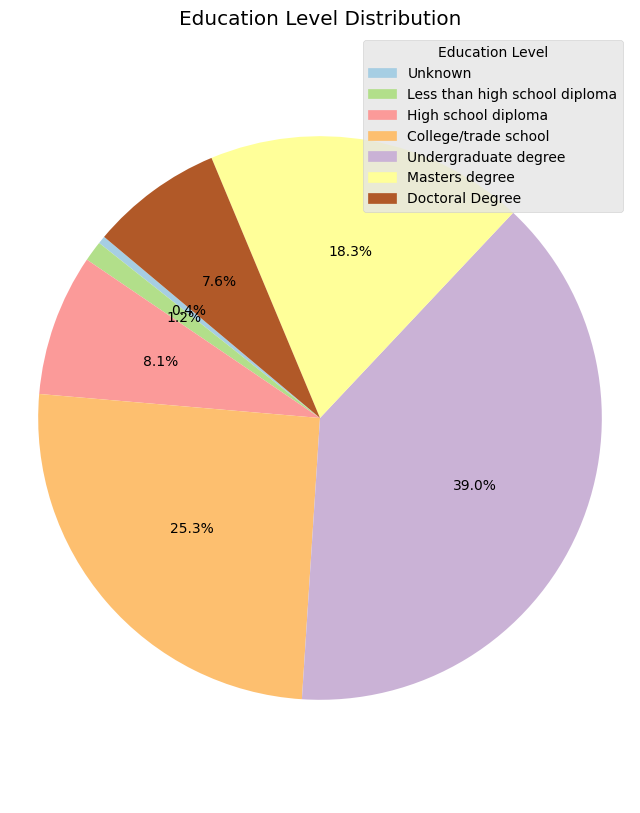

In [27]:
colors = plt.cm.Paired(np.linspace(0, 1, len(df1['Maternal_Education'].unique())))

education_order = [
    'Unknown',
    'Less than high school diploma',
    'High school diploma',
    'College/trade school',
    'Undergraduate degree',
    'Masters degree',
    'Doctoral Degree'
]

# Get the counts of each education level and sort by the desired order
education_count = df1['Maternal_Education'].value_counts()
education_count = education_count.reindex(education_order)

# education_count = df['Maternal_Education'].value_counts().sort_index(ascending = True)
patches = [mpatches.Patch(color=colors[index], label=category) for index, category in enumerate(education_count.index)]
plt.figure(figsize=(8, 10))
plt.pie(
    education_count.values,
    autopct='%1.1f%%', startangle=140, shadow=False, colors=colors)
plt.title('Education Level Distribution')
plt.legend(handles=patches, title='Education Level', loc='upper right')
plt.axis('equal')
plt.show()


#### 2. Measurements of COVID threats, anxiety, and depressive symptoms.

Histograms of a) EPDS scale, b) PROMIS Anxiety scale, and c) three ratings of COVID questions.

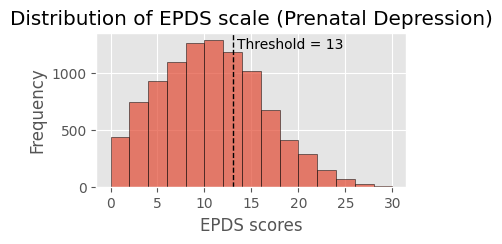

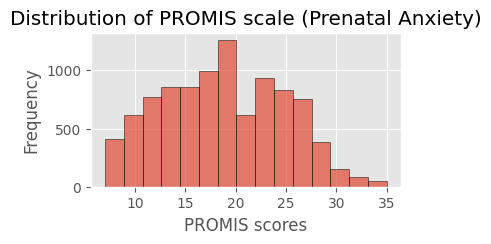

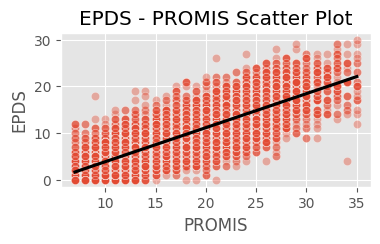

In [28]:
# a. Histogram for EPDS distribution (with the clinical cut-off >= 13)
plt.figure(figsize=(4,2))
plt.hist(df1['EPDS'].dropna(), bins = 15, edgecolor='k', alpha=0.7)
plt.axvline(x = 13, color='black', linestyle='dashed', linewidth=1, label='threshold = 13')
plt.text(13.5, plt.ylim()[1] * 0.9, 'Threshold = 13', color='black', fontsize=10)

plt.title('Distribution of EPDS scale (Prenatal Depression)')
plt.xlabel('EPDS scores')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# b. Histogram for PROMIS scale distribution
plt.figure(figsize=(4,2))
plt.hist(df1['PROMIS_Anxiety'].dropna(), bins = 15, edgecolor='k', alpha=0.7)
plt.title('Distribution of PROMIS scale (Prenatal Anxiety)')
plt.xlabel('PROMIS scores')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot EPDS vs. PROMIS
plt.figure(figsize=(4,2))
sns.scatterplot(data=df1, x='PROMIS_Anxiety', y='EPDS', alpha = 0.4)
sns.regplot(data=df1, x='PROMIS_Anxiety', y='EPDS', scatter=False, color='black', ci=95)

plt.title('EPDS (depression) vs. PROMIS (anxiety)')
plt.ylabel('EPDS')
plt.xlabel('PROMIS')
plt.title('EPDS - PROMIS Scatter Plot')
plt.grid(True)
plt.show()


In [29]:
# Pearson cor between EPDS and PROMIS
r, p = stats.pearsonr(df1.dropna(subset=['EPDS', 'PROMIS_Anxiety'])['EPDS'],df1.dropna(subset=['EPDS', 'PROMIS_Anxiety'])['PROMIS_Anxiety'])

# Print the correlation coefficient and p-value
print(f"Pearson's correlation coefficient: {r:.2f}\np-value: {p:.4f}")


Pearson's correlation coefficient: 0.81
p-value: 0.0000


This indicates a significant correlation between maternal despressive and anxiety symptoms during pregnancy.

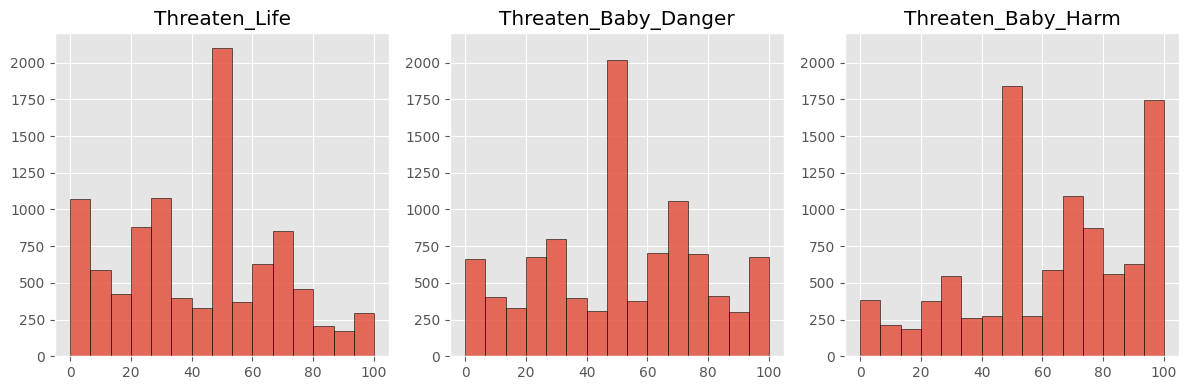

In [30]:
# c. three covid threat question ratings distribution.
from matplotlib.gridspec import GridSpec

fig_threat = plt.figure(figsize=(12,4))
gs = GridSpec(1, 3)

ax1 = fig_threat.add_subplot(gs[0, 0])
ax1.hist(df1['Threaten_Life'].dropna(), bins = 15, edgecolor='k', alpha = 0.8)
ax1.set_title('Threaten_Life')

ax2 = fig_threat.add_subplot(gs[0, 1])
ax2.hist(df1['Threaten_Baby_Danger'].dropna(), bins = 15, edgecolor='k', alpha = 0.8)
ax2.set_title('Threaten_Baby_Danger')

ax3 = fig_threat.add_subplot(gs[0, 2])
ax3.hist(df1['Threaten_Baby_Harm'].dropna(), bins = 15, edgecolor='k', alpha = 0.8)
ax3.set_title('Threaten_Baby_Harm')

axs = [ax1, ax2, ax3]
for ax in [ax1, ax2, ax3]:
    ax.set_ylim(0, 2200)

# Adjust layout to ensure proper spacing
plt.tight_layout()
plt.show()

#### 3. Birth Outcomes

Histograms of birth gestational age, weight, and length.


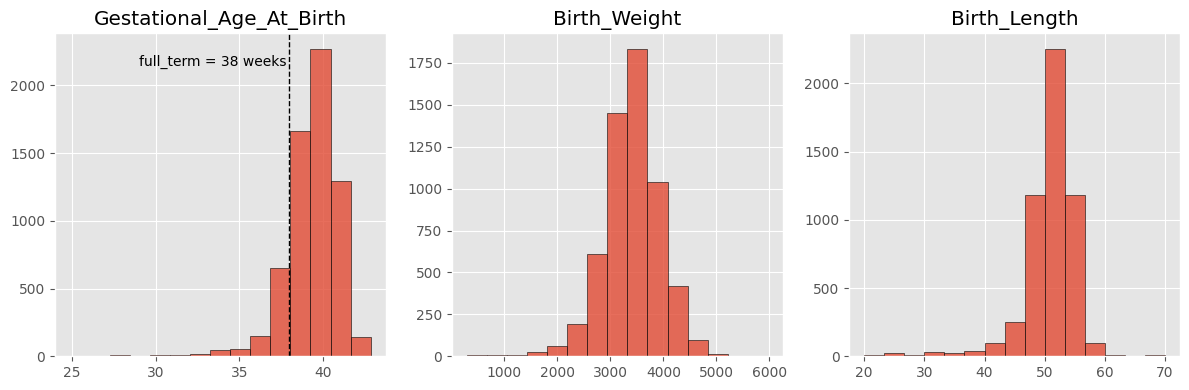

In [31]:
# distribution of 3 continuous birth measures.
fig_birth = plt.figure(figsize=(12,4))
gs = GridSpec(1, 3)

ax1 = fig_birth.add_subplot(gs[0, 0])
ax1.hist(df1['Gestational_Age_At_Birth'].dropna(), bins = 15, edgecolor='k', alpha=0.8)
plt.axvline(x = 38, color='black', linestyle='dashed', linewidth=1)
plt.text(29, plt.ylim()[1] * 0.9, 'full_term = 38 weeks', color='black', fontsize=10)
ax1.set_title('Gestational_Age_At_Birth')

ax2 = fig_birth.add_subplot(gs[0, 1])
ax2.hist(df1['Birth_Weight'].dropna(), bins = 15, edgecolor='k', alpha=0.8)
ax2.set_title('Birth_Weight')

ax3 = fig_birth.add_subplot(gs[0, 2])
ax3.hist(df1['Birth_Length'].dropna(), bins = 15, edgecolor='k', alpha=0.8)
ax3.set_title('Birth_Length')

axs = [ax1, ax2, ax3]

# Adjust layout to ensure proper spacing
plt.tight_layout()
plt.show()

Barplots of delivery mode and NICU admission.

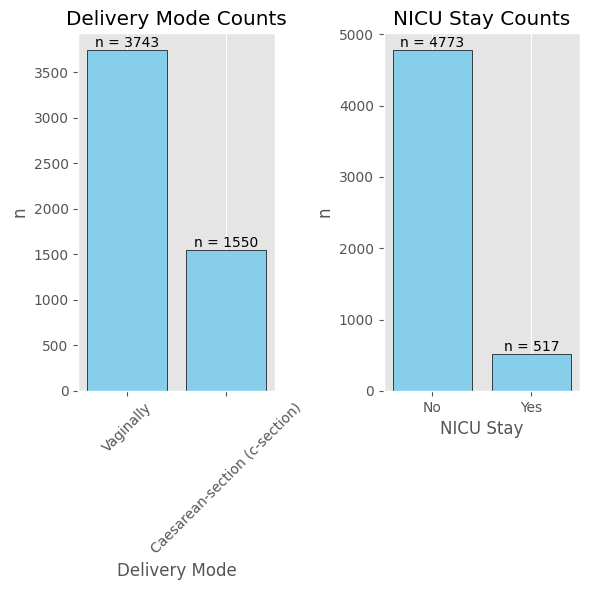

In [32]:
# Bar Plot for delivery mode
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(df1['Delivery_Mode'].value_counts().index, df1['Delivery_Mode'].value_counts().values, color='skyblue', edgecolor='k')
# n per language group
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'n = {height}', ha='center', va='bottom')

plt.title('Delivery Mode Counts')
plt.xlabel('Delivery Mode')
plt.ylabel('n')
# rotate x axis 45
plt.xticks(rotation=45)
plt.grid(axis='y')


# Bar Plot for nicu stay
plt.subplot(1, 2, 2)
bars = plt.bar(df1['NICU_Stay'].value_counts().index, df1['NICU_Stay'].value_counts().values, color='skyblue', edgecolor='k')
# n per language group
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'n = {height}', ha='center', va='bottom')

plt.title('NICU Stay Counts')
plt.xlabel('NICU Stay')
plt.ylabel('n')
plt.grid(axis='y')

# Plot output
plt.tight_layout()
plt.show()

## Data Analysis


### Question 1:

### Are the COVID-fear measures realible and reflective of a general fear of COVID?

Given that three questions were asked about the interviewee's fear about COVID in different aspects,

1. Cronbach's Alpha to assess internal consistency of the 3 question scales (pingouin)
2. A Exploratory Factor Analysis (factor_analyzer)
3. A Confirmatory Factor Analysis (semopy/R-lavaan)

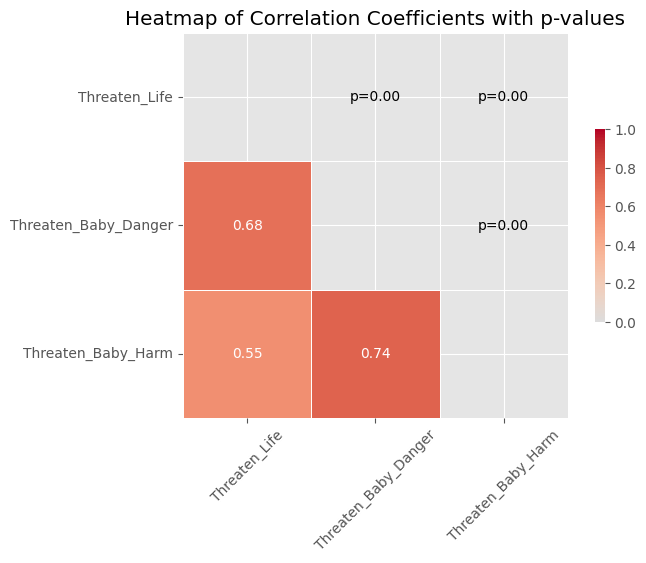

In [33]:
# subset data from df1
colnames = df1.columns[[13,14,15]].tolist()
data_cfa = df1.loc[:, colnames].astype(float)

# get the cronbach's alpha
cronbach_alpha(data_cfa)

# pairwise correlation
dmatrix = data_cfa.corr()

# calculate p-values
p_values = data_cfa.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*dmatrix.shape)

# display the upper triangle
mask = np.triu(np.ones_like(dmatrix, dtype=bool))

# plot heatmap
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(dmatrix, mask = mask, cmap = "coolwarm", vmin = 0, vmax= 1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .5})

# p-values on the upper triangle
for i in range(len(dmatrix)):
    for j in range(i+1, len(dmatrix)):
        text = ax.text(j+0.5, i+0.5, f'p={p_values.iloc[i, j]:.2f}',
                       ha='center', va='center', color='black')
plt.xticks(rotation=45)
plt.title("Heatmap of Correlation Coefficients with p-values")
plt.show()

The Cronbach's alpha value of the three COVID-related fear questions is **0.853** (95% CI: [0.848, 0.858]), indicating a good reliability.

**2. Exploratory Factor Analysis (EFA)**
  - Use the factor_analyzer module.
  - EFA to investigate the underlying structure without imposing a pre-specified model. This can provide preliminary evidence that the three variables may load onto a single factor.

In [34]:
# EFA with factoranalyzer
fa = FactorAnalyzer(n_factors=1, rotation=None)
fa.fit(data_cfa)
# print the fa.loadings and variance explained in the format of : variable_name1: loading, % explained \n
loadings_df = pd.DataFrame(data = fa.loadings_, index = data_cfa.columns, columns = ['Loading'])
print('loadings and variance explained of each variable:')
for variable, loading in loadings_df['Loading'].items():
    print(f'{variable}: {loading}, {loading**2*100:2.2f}% explained')


loadings and variance explained of each variable:
Threaten_Life: 0.7152628292428914, 51.16% explained
Threaten_Baby_Danger: 0.9539691618005487, 91.01% explained
Threaten_Baby_Harm: 0.7744530339756941, 59.98% explained


All the loadings are above 0.7, suggesting that they all strongly relate to the one latent factor, likely measuring the same underlying contrusct, in the case, overall COVID-19 fear.

**3. Confirmatory Factor Analysis (CFA)**

To further confirm the proposal, a CFA was conducted. Considering the just-identified model problem with only 3 variables involved, an efa.explore_cfa_model from semopy and a CFA model with a latent-variable self-correlation restraint in R (lavaan) were run, with the latter in the attempt to replicate the identical model from Giesbrecht, Rojas, Patel, et al., 2023.

In [35]:
# New function to propose the best CFA structure (with caution, as it's not published/peer-reviewed yet)
semopy.efa.explore_cfa_model(data_cfa)

# Construct the COVID-fear latent variable by averaging the scaled scores of the three questions.
df1['COVID_fear'] = ((df1['Threaten_Life'] - df1['Threaten_Life'].mean()) / df1['Threaten_Life'].std() +
                     (df1['Threaten_Baby_Danger'] - df1['Threaten_Baby_Danger'].mean()) / df1['Threaten_Baby_Danger'].std() +
                     (df1['Threaten_Baby_Harm'] - df1['Threaten_Baby_Harm'].mean()) / df1['Threaten_Baby_Harm'].std())/ 3

# Save the cleaned and processed df1 file
# df1.to_csv(os.getcwd() + '/data/df1.csv', index=False)

Alternatively, we can also use R's lavaan package to create the CFA model that frees the parameter of the first variable to the latent variable, while restricting a r = 1 self-correlation of the latent variable itself.

In [ ]:
# Run R env on colab
!apt-get install -y r-base
%load_ext rpy2.ipython

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pd.DataFrame.iteritems = pd.DataFrame.items

# Activate the automatic conversion of pandas DataFrame to R DataFrame
pandas2ri.activate()

# Convert the pandas DataFrame to an R DataFrame
ro.globalenv['data_cfa'] = pandas2ri.py2rpy(data_cfa)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.0-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
%%R
# first time run needs lavaan installing, take ~1min long.
if (!require('lavaan')) {
  install.packages('lavaan')
}

library(lavaan)
df <- as.data.frame(data_cfa)

# Define the CFA model
model <- '
Fear_of_COVID =~ NA*Threaten_Life + Threaten_Baby_Danger + Threaten_Baby_Harm
Fear_of_COVID ~~ 1*Fear_of_COVID
'

# Fit the CFA model
fit <- cfa(model, data=df)

# Summary of the model fit
summary(fit, fit.measures=TRUE, standardized = TRUE)

# library(tidySEM)
# this installation could take longer on colab.
# A graph from Rstudio is inserted below instead.
# graph_sem(model = fit)

lavaan 0.6-18 ended normally after 15 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         6

  Number of observations                          9844

Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Model Test Baseline Model:

  Test statistic                             14039.045
  Degrees of freedom                                 3
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    1.000
  Tucker-Lewis Index (TLI)                       1.000

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)            -131644.750
  Loglikelihood unrestricted model (H1)    -131644.750
                                                

The estimated model from R-lavaan package:

![](https://drive.google.com/uc?export=view&id=1CufdS2yOES5WQ3A6jPFRZ-7aJ6eZbKzn)


Based on modeling results from three approaches above, it is safe to confirm that the three "COVID threat" questions could be represented by a single latent variable. To simplify this, we created a new column called COVID_fear, which averages the standardized ratings of these three questions to represent overall concern about COVID-19 during pregnancy.

Next, we build an exploratory linear model (ANOVA) to see if certain demographic factors influence this concern level. The factors we look at include:

- Household Income (categorical)
- Maternal Age (continuous)
- Maternal Education (categorical)
- Survey Language (categorical)

In [36]:
# Prepare the data by converting categorical variables to category dtype
df1['Household_Income'] = df1['Household_Income'].astype('category')
df1['Maternal_Education'] = df1['Maternal_Education'].astype('category')
df1['Language'] = df1['Language'].astype('category')

categorical_columns = ['Household_Income', 'Maternal_Education', 'Language']

# Prior to the model fitting, check multicollinearity between these categorical variables via cramer's V:
def cramers_v(x, y):
    cm = pd.crosstab(x, y) # confusion_matrix
    chi2_value = stats.chi2_contingency(cm)[0]
    n = cm.sum().sum()
    phi2 = chi2_value / n
    r, k = cm.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df1[col1], df1[col2])

print(cramers_v_matrix)


                   Household_Income Maternal_Education  Language
Household_Income                1.0           0.388383  0.174428
Maternal_Education         0.388383                1.0  0.140761
Language                   0.174428           0.140761       1.0


The Cramer's V values for each combination of the three categorical variables show a weak to moderate degree of multicollinearity among them.

Next, we run a linear regression model on `COVID_fear`:

In [37]:
# For the regression model including categorical factors as a whole
formula = 'COVID_fear ~ Maternal_Age + C(Household_Income) + C(Maternal_Education) + C(Language)'
# Fit the regression model using the formula API
model = smf.ols(formula, data=df1).fit()

# Perform ANOVA on the regression model
anova_results = sm.stats.anova_lm(model, typ=2)

# coefficients for each level of factors
model.summary()

# Display the ANOVA results
print(anova_results)

                            sum_sq      df           F        PR(>F)
C(Household_Income)      51.064801     9.0    7.529702  4.576553e-11
C(Maternal_Education)    22.901719     6.0    5.065420  3.369628e-05
C(Language)              82.057854     1.0  108.897723  2.320547e-25
Maternal_Age              6.081176     1.0    8.070236  4.509111e-03
Residual               7379.333048  9793.0         NaN           NaN


The ANOVA table suggested that all four factors significantly influenced the maternal covid fear level.

In `model.summary`, for the only continuous variable Maternal Age, it shows 1 year of maternal age increase would decrease the covid_fear score (standardized) by 0.0061.


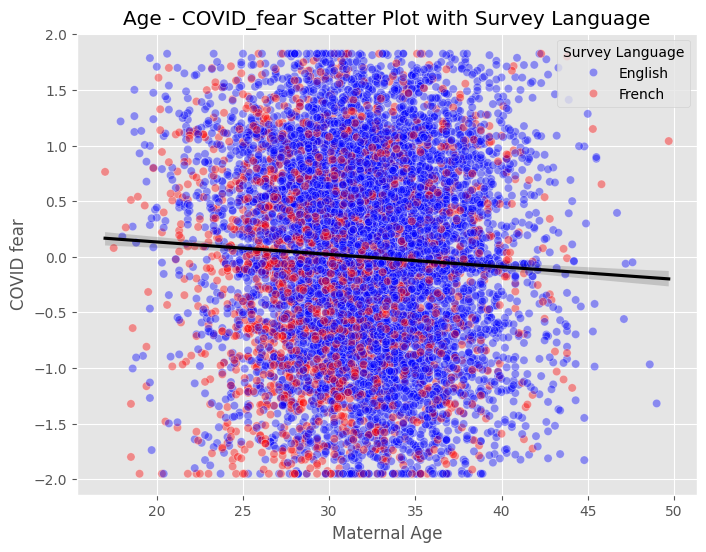

In [38]:
# Plot age vs. COVID_fear, adding language as a grouping factor.
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df1, x='Maternal_Age', y='COVID_fear', hue='Language', palette={'English': 'blue', 'French': 'red'}, alpha = 0.4)
sns.regplot(data=df1, x='Maternal_Age', y='COVID_fear', scatter=False, color='black', ci=95)

plt.xlabel('Maternal Age')
plt.ylabel('COVID fear')
plt.title('Age - COVID_fear Scatter Plot with Survey Language')
plt.legend(title='Survey Language', loc='upper right')
plt.grid(True)
plt.show()

# from scipy.stats import pearsonr
# pearsonr(df1['Maternal_Age'][~df1['Maternal_Age'].isnull()], df1['COVID_fear'][~df1['Maternal_Age'].isnull()])


Post-hoc pair-wise analysis is then conducted on three categorical factors.

In [39]:
# post-hoc tukey pairwise tests.
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
df1['Language'].isnull().sum()

# perform Tukey's HSD test for each factor
factors = ['Household_Income', 'Maternal_Education', 'Language']
factor = 'Household_Income'
dependent_var = 'COVID_fear'

for factor in factors:
    result = MultiComparison(df1[dependent_var], df1[factor])
    tukey_result = result.tukeyhsd(alpha = .05)
    print(f"Tukey's HSD results for {factor}:\n", tukey_result.summary())
    # optional plot (similar to R's emmip)
    # tukey_result.plot_simultaneous(figsize=(8, 6))

# or directy use pairwise tukeyhsd, it's just less easy to customize to other methods.
    # tukey_result2 = pairwise_tukeyhsd(df1[dependent_var], df1[factor])
    # print(f"Tukey's HSD results for {factor}:\n", tukey_result2)
    # tukey_result.plot_simultaneous(figsize = (8,6))

Tukey's HSD results for Household_Income:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.3259 0.1904 -0.0618  0.7137  False
     0      2   0.2514 0.4423 -0.1068  0.6097  False
     0      3   0.1207 0.9846 -0.2259  0.4674  False
     0      4    0.067 0.9998 -0.2768  0.4108  False
     0      5   0.0212    1.0 -0.3229  0.3653  False
     0      6   -0.015    1.0 -0.3617  0.3318  False
     0      7  -0.0368    1.0 -0.3851  0.3115  False
     0      8  -0.0655 0.9999 -0.4212  0.2902  False
     0      9  -0.0781 0.9995 -0.4278  0.2716  False
     1      2  -0.0745 0.9889 -0.2985  0.1495  False
     1      3  -0.2052 0.0494 -0.4102 -0.0002   True
     1      4   -0.259 0.0017 -0.4591 -0.0588   True
     1      5  -0.3047 0.0001 -0.5054  -0.104   True
     1      6  -0.3409    0.0 -0.5461 -0.1357   True
     1      7  -0.3627    0.0 -0.5705  -0.155   True
   

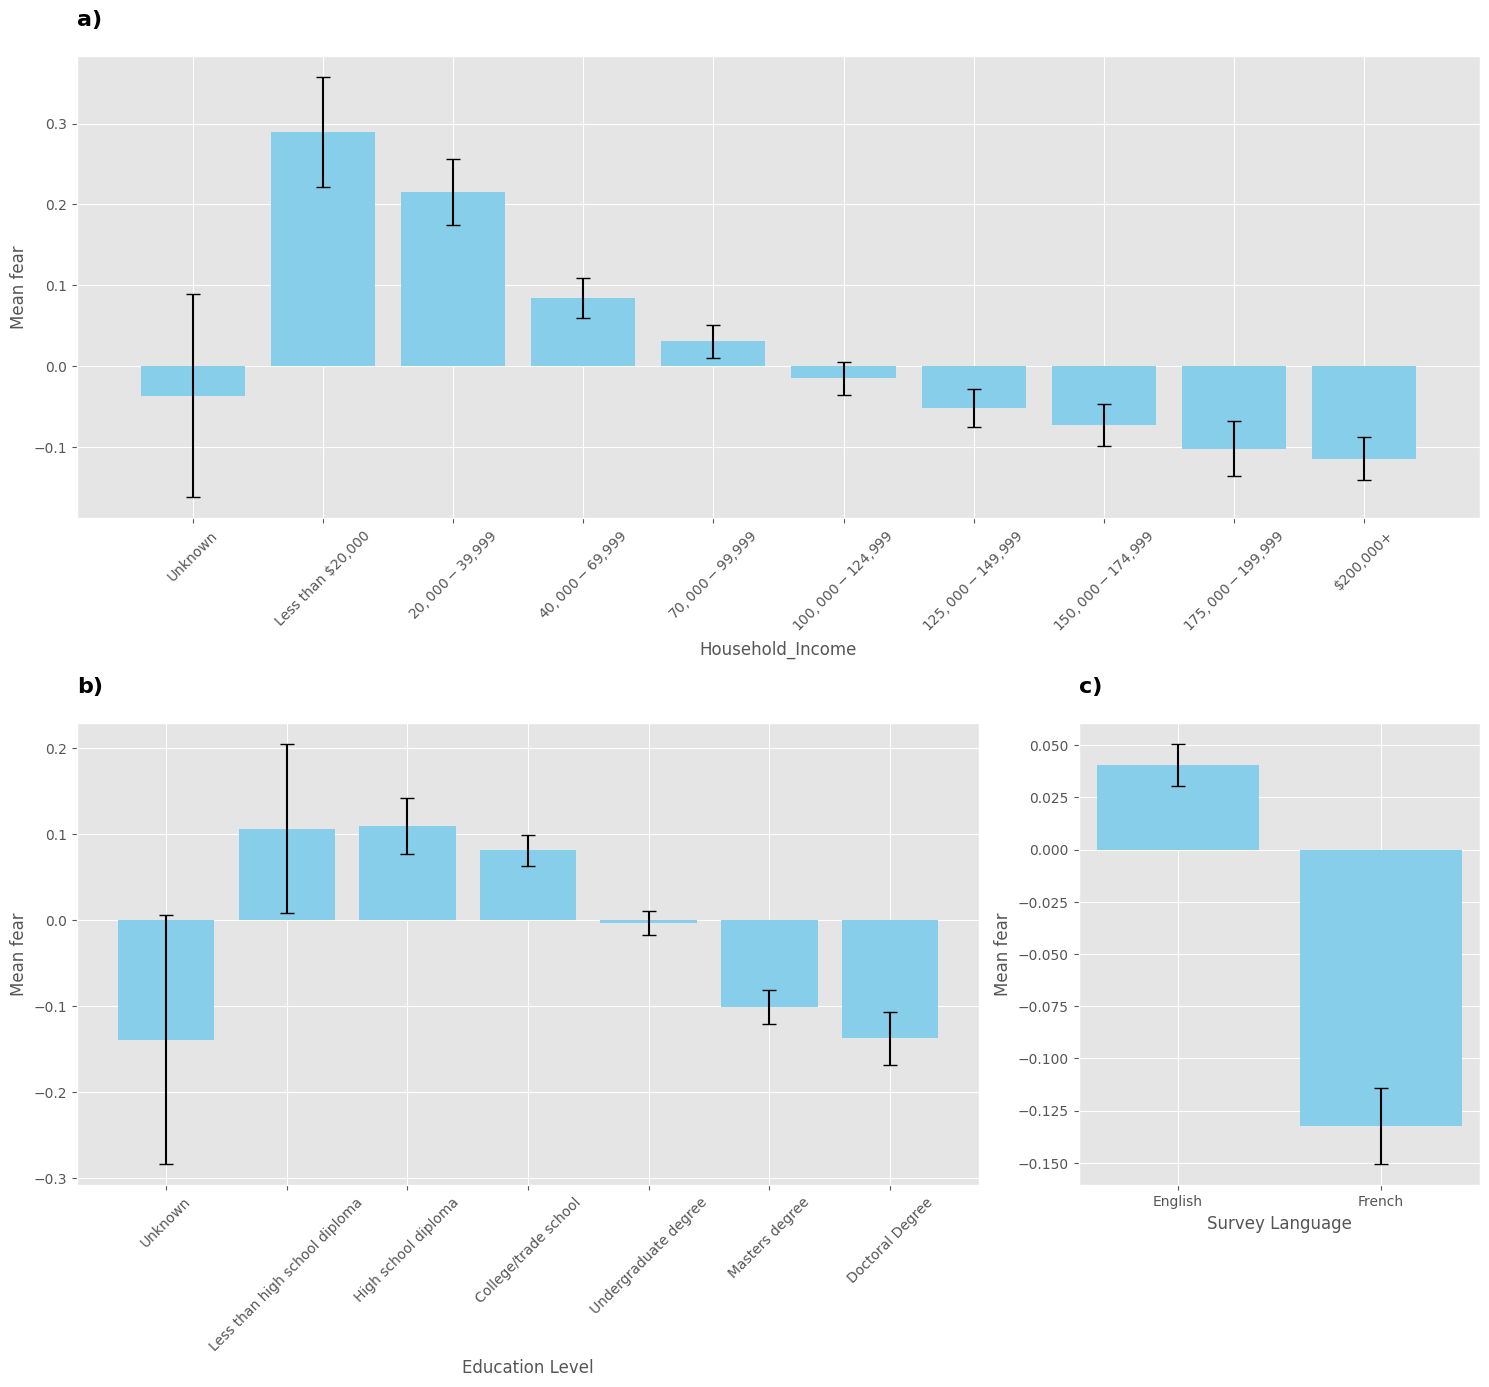

In [40]:
# visualization of mean COVID_fear by each significant condition
def create_mean_fear(df, iv_name, dv_name):
    mean_fear = df.groupby(iv_name)[dv_name].agg(['mean', 'count', 'std']).reset_index()
    mean_fear['se'] = mean_fear['std'] / np.sqrt(mean_fear['count'])
    return mean_fear

# create mean fear DataFrames for three figures
mean_fear1 = create_mean_fear(df1, 'Household_Income', 'COVID_fear')
mean_fear2 = create_mean_fear(df1, 'Maternal_Education', 'COVID_fear')
mean_fear3 = create_mean_fear(df1, 'Language', 'COVID_fear')

# reorder mean_fear2 Education for visualization
new_order = [
    'Unknown',
    'Less than high school diploma',
    'High school diploma',
    'College/trade school',
    'Undergraduate degree',
    'Masters degree',
    'Doctoral Degree'
]

# convert the Maternal_Education column to a categorical type with the desired order
mean_fear2['Maternal_Education'] = pd.Categorical(mean_fear2['Maternal_Education'], categories=new_order, ordered=True)
mean_fear2.sort_values('Maternal_Education', inplace=True)

# plotting the summarized mean fear for each cat-factor
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 14))
gs = GridSpec(2, 3)

# plot for top
ax1 = fig.add_subplot(gs[0, :])
ax1.bar(mean_fear1['Household_Income'].map(level_to_income), mean_fear1['mean'], yerr=mean_fear1['se'], capsize=5, color='skyblue')
ax1.set_xlabel('Household_Income')
ax1.set_ylabel('Mean fear')
ax1.tick_params(axis='x', rotation=45)

# plot for bottom left
ax2 = fig.add_subplot(gs[1, 0:2])
ax2.bar(mean_fear2['Maternal_Education'], mean_fear2['mean'], yerr=mean_fear2['se'], capsize=5, color='skyblue')
ax2.set_xlabel('Education Level')
ax2.set_ylabel('Mean fear')
ax2.tick_params(axis='x', rotation=45)

# plot for bottom right
ax3 = fig.add_subplot(gs[1, 2])
ax3.bar(mean_fear3['Language'], mean_fear3['mean'], yerr=mean_fear3['se'], capsize=5, color='skyblue')
ax3.set_xlabel('Survey Language')
ax3.set_ylabel('Mean fear')
ax3.tick_params(axis='x')

axs = [ax1, ax2, ax3]
# annotation
annotations = ['a)', 'b)', 'c)']
for i, ax in enumerate(axs):
    if i < len(annotations):
        ax.text(0, 1.1, annotations[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')

plt.tight_layout()
plt.show()


#### Summary
This provides some insightful information on how household income, education level, and survey language significantly impact COVID-19 fear:

##### *Household Income*
- **Higher Fear at Lower Income Levels**:
  - The highest mean fear is observed in the lower income brackets ("Less than \$20,000" and "$20,000-39,999").
  - As income increases, the mean fear decreases, becoming negative in the higher income brackets ("150,000-199,999" and "200,000+").
  - This suggests that individuals with lower household incomes experience higher levels of fear related to COVID-19, compared to those with higher incomes.

##### *Education Level*
- **Higher Fear at Lower Education Levels**:
  - Similar to income, lower education levels (e.g., "Less than high school diploma" and "High school diploma") are associated with higher mean fear.
  - Fear decreases as the education level increases, with individuals holding "Masters degree" and "Doctoral Degree" showing negative mean fear.
  - This indicates that individuals with higher education levels tend to have lower levels of COVID-19 fear.

##### *Survey Language*
- **Language-Based Differences in Fear**:
  - There is a notable difference between English and French survey respondents.
  - Participants responded in English (n = 7538) show a slight positive mean fear, while French respondents (n = 2303) show a significant negative mean fear.
  - This suggests that language and potentially cultural differences influence the level of fear related to COVID-19.


### Question 2:

### Does maternal fear about COVID associate with maternal anxiety and depression levels during pregnancy?

(1) Given that there is a cut-off criterion in both scales measuring the maternal depressive symptoms and anxiety,
binomial logistic regressions are performed using a logit link function:

- `glm(EPDS ~ fear)`

- `glm(anxiety ~ fear)`


Adjusted models further include demographic factors `Maternal_Age`, `Maternal_Education`, `Household_Income` and `Language`.




*Limitation: The current dataset misses other potentially influential factors, such as history of anxiety and depression, minority ethnicity, history of other chronic illnesses, residence location, etc.*

In [41]:
# drop the missing values in the depression/anxiety measure columns ==> cleaned dataframe shape: (9536,16)
# saved as df2 for Goal_2: fear <-> EPDS
df2 = df1.dropna(subset=['EPDS', 'PROMIS_Anxiety', 'Maternal_Age'])
# display the analysis_ready form of df
df2.head(n = 5)

# check how many missing data in each column
df2.isnull().sum()
df2.shape

# save df2
# df2.to_csv(os.getcwd() + '/data/df2.csv', index=False)

(9536, 17)

#### COVID_fear & Depressive Symptoms (EPDS)

The prenatal depression was measured using Edinburgh Postnatal Depression Scale (EPDS). Though it's designed originally for postnatal depression, it has been shown to effective reflect prenatal depression as well (e.g., Bergink, Kooistra, Lambregtse-van den Berg et al., 2011; Kozinszky & Dudas, 2015).

A cut-off of 13 is used to decide the presence of the clinical depression symptoms.

- participants w/o clinical symptoms: n = 6364
- participants with clinical symptoms: n = 3172


`Model 1: glm(EPDS ~ fear)`

In [42]:
# Test the simple GLM model:
df2['EPDS_cat'] = np.where(df2['EPDS'] >= 13, 1, 0)
df2.isnull().sum()

df2.groupby('EPDS_cat').count()


# default is logit link function
small_model = smf.glm(formula = 'EPDS_cat ~ COVID_fear', data = df2, family = sm.families.Binomial()).fit()
small_model.summary()

# Calculate odds ratios
odds_ratios = np.exp(small_model.params)
conf = np.exp(small_model.conf_int())
conf['OR'] = odds_ratios
conf.columns = ['2.5%', '97.5%', 'OR']
print(conf)

# How does the full model perform:
predicted_probs = small_model.predict(df2)

# Predict classes based on threshold 0.5
predicted_classes = (predicted_probs >= 0.5).astype(int)

# Construct confusion matrix and balanced accuracy
conf_matrix = confusion_matrix(df2['EPDS_cat'], predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy:{(conf_matrix[0,0] + conf_matrix[1,1])/conf_matrix.sum():.2f}")

                2.5%     97.5%        OR
Intercept   0.446296  0.488653  0.466994
COVID_fear  1.941072  2.164169  2.049587
Confusion Matrix:
[[5893  471]
 [2471  701]]
Accuracy:0.69


`Adjusted Model 1: glm(EPDS ~ fear + Maternal_Age + Maternal_Education + Household_Income + Language)`

In [43]:
# Adjusted model (considering other demographic data)
# extract column names
all_factors = ['COVID_fear', 'Maternal_Education', 'Household_Income', 'Language', 'Maternal_Age']
cat_factors = {'Maternal_Education', 'Household_Income', 'Language'}

# Define the dependent variable
dv = 'EPDS_cat'

# Function to generate the formula
def generate_formula(excluded_factor):
    global dv
    global cat_factors
    global all_factors
    included_factors = [f'C({factor})' if factor in cat_factors else factor
                        for factor in all_factors if factor != excluded_factor]
    formula = f"{dv} ~ " + " + ".join(included_factors)
    return formula

formula = 'EPDS_cat ~ COVID_fear + C(Household_Income) + C(Maternal_Education) + C(Language) + Maternal_Age'
# default is logit link function
big_model = smf.glm(formula=formula, data=df2, family=sm.families.Binomial()).fit()
table_result2 = []
# big_model.summary()
for factor in all_factors:
    formula_reduced = generate_formula(factor)
    # Fit the reduced logistic regression model using the formula API
    model_reduced = smf.logit(formula_reduced, data=df2).fit()

    # Perform the likelihood ratio test
    lr_stat = 2 * (big_model.llf - model_reduced.llf)
    degree_f = big_model.df_model - model_reduced.df_model
    p_value = stats.chi2.sf(lr_stat, degree_f)
    table_result2.append((factor, lr_stat, degree_f, p_value))

# Create a DataFrame to display the ANOVA results
anova_df2 = pd.DataFrame(table_result2, columns=['Factor', 'Likelihood Ratio', 'df', 'p-value'])
print(anova_df2)

Optimization terminated successfully.
         Current function value: 0.613777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.581180
         Iterations 5
               Factor  Likelihood Ratio   df        p-value
0          COVID_fear        623.450809  1.0  1.328073e-137
1  Maternal_Education         59.663082  6.0   5.269186e-11
2    Household_Income        112.748149  9.0   4.050402e-20
3            Language         21.204369  1.0   4.128224e-06
4        Maternal_Age          1.754245  1.0   1.853440e-01


In [44]:
# Odds Ratio and Prediction Accuracies
odds_ratios = np.exp(big_model.params)
conf = np.exp(big_model.conf_int())
conf['OR'] = odds_ratios
conf.columns = ['2.5%', '97.5%', 'OR']
print(conf)

# How does the full model perform:
predicted_probs = big_model.predict(df2)

# Predict classes based on threshold 0.5
predicted_classes = (predicted_probs >= 0.5).astype(int)

# Construct confusion matrix and balanced accuracy
conf_matrix = confusion_matrix(df2['EPDS_cat'], predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy:{(conf_matrix[0,0] + conf_matrix[1,1])/conf_matrix.sum():.2f}")

                                                        2.5%     97.5%  \
Intercept                                           0.470315  3.895298   
C(Household_Income)[T.1]                            0.332878  2.702228   
C(Household_Income)[T.2]                            0.397536  3.061632   
C(Household_Income)[T.3]                            0.266663  2.013569   
C(Household_Income)[T.4]                            0.240617  1.808375   
C(Household_Income)[T.5]                            0.188426  1.417666   
C(Household_Income)[T.6]                            0.180946  1.368997   
C(Household_Income)[T.7]                            0.148025  1.124921   
C(Household_Income)[T.8]                            0.143550  1.109332   
C(Household_Income)[T.9]                            0.165068  1.259653   
C(Maternal_Education)[T.Doctoral Degree]            0.513923  0.776318   
C(Maternal_Education)[T.High school diploma]        0.844116  1.201838   
C(Maternal_Education)[T.Less than high

After accounting for the *available* demographic information from the data, **fear of COVID still significantly contributes to the presence of pre-natal depressive symptoms**: A one-unit increase in the `COVID_fear` index approximately doubles the likelihood of experiencing these symptoms.

#### COVID_fear & Anxiety (PROMIS)

The general anxiety index was measured from the Patient-Reported Outcomes Measurement Information
System (PROMIS®) Anxiety Adult 7-item short form. Here, we convert raw scores into t-scores based on the US general population data. A cut-off of t >= 60 is used to decide the presence of the clinical anxiety symptoms.

- participants w/o clinical symptoms: n = 5066
- participants with clinical symptoms: n = 4470


`Model 2: glm(anxiety ~ fear)`

In [45]:
# Data minor-manipulation
df2['anxiety_cat'] = np.where(df2['PROMIS_Anxiety'] >= 60, 1, 0)
df2.isnull().sum()

# anxiety data glimpse:
df2['PROMIS_Anxiety'].describe()

# raw to tscore
conversion_promis = pd.read_csv(os.getcwd() + '/data/conversion_promis.csv')

# Merge the datasets on 'PROMIS_Anxiety' and 'raw_score'
df2 = df2.merge(conversion_promis, left_on='PROMIS_Anxiety', right_on='raw', how='left')

# Update the 'PROMIS_Anxiety' column with the 't_score'
df2['anxiety_tscore'] = df2['tscore']
df2.drop(columns=['raw', 'se'], inplace=True)

df2['anxiety_cat'] = np.where(df2['anxiety_tscore']>=60, 1, 0)

# count ppl in each group
df2.groupby(df2['anxiety_cat']).count()

# copresence of the anxiety and depressive symptoms:
df2.groupby(['anxiety_cat', 'EPDS_cat']).count().iloc[:,1]

anxiety_cat  EPDS_cat
0            0           4677
             1            389
1            0           1687
             1           2783
Name: Maternal_Age, dtype: int64

In [46]:
# Test the simple GLM model:
# default is logit link function
small_model2 = smf.glm(formula = 'anxiety_cat ~ COVID_fear', data = df2, family = sm.families.Binomial()).fit()
small_model2.summary()

# Calculate odds ratios
odds_ratios = np.exp(small_model2.params)
conf = np.exp(small_model2.conf_int())
conf['OR'] = odds_ratios
conf.columns = ['2.5%', '97.5%', 'OR']
print(conf)

# How does the full model perform:
predicted_probs = small_model2.predict(df2)

# Predict classes based on threshold 0.5
predicted_classes = (predicted_probs >= 0.5).astype(int)

# Construct confusion matrix and balanced accuracy
conf_matrix = confusion_matrix(df2['anxiety_cat'], predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy:{(conf_matrix[0,0] + conf_matrix[1,1])/conf_matrix.sum():.2f}")

                2.5%     97.5%        OR
Intercept   0.828387  0.902429  0.864616
COVID_fear  2.216364  2.464427  2.337107
Confusion Matrix:
[[3521 1545]
 [1784 2686]]
Accuracy:0.65


`Adjusted Model 2: glm(anxiety ~ fear + Maternal_Age + Maternal_Education + Household_Income + Language)`

In [47]:
# Adjusted model (considering other demographic data)
all_factors = ['COVID_fear', 'Maternal_Education', 'Household_Income', 'Language', 'Maternal_Age']
cat_factors = {'Maternal_Education', 'Household_Income', 'Language'}

# Define the dependent variable
dv = 'anxiety_cat'

formula = 'anxiety_cat ~ COVID_fear + C(Household_Income) + C(Maternal_Education) + C(Language) + Maternal_Age'
# default is logit link function
big_model2 = smf.glm(formula=formula, data=df2, family=sm.families.Binomial()).fit()
table_result_ax = []
# big_model.summary()
for factor in all_factors:
    formula_reduced = generate_formula(factor)
    # Fit the reduced logistic regression model using the formula API
    model_reduced = smf.logit(formula_reduced, data=df2).fit()

    # Perform the likelihood ratio test
    lr_stat = 2 * (big_model2.llf - model_reduced.llf)
    degree_f = big_model2.df_model - model_reduced.df_model
    p_value = stats.chi2.sf(lr_stat, degree_f)
    table_result_ax.append((factor, lr_stat, degree_f, p_value))

# Create a DataFrame to display the ANOVA results
anova_df_ax = pd.DataFrame(table_result_ax, columns=['Factor', 'Likelihood Ratio', 'df', 'p-value'])
print(anova_df_ax)

Optimization terminated successfully.
         Current function value: 0.674364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621923
         Iterations 5
               Factor  Likelihood Ratio   df        p-value
0          COVID_fear       1008.317103  1.0  2.795341e-221
1  Maternal_Education         24.540143  6.0   4.152901e-04
2    Household_Income         68.202095  9.0   3.425021e-11
3            Language         41.930213  1.0   9.458976e-11
4        Maternal_Age          8.162932  1.0   4.275518e-03


In [48]:
# Odds Ratio and Prediction Accuracies
odds_ratios = np.exp(big_model2.params)
conf = np.exp(big_model2.conf_int())
conf['OR'] = odds_ratios
conf.columns = ['2.5%', '97.5%', 'OR']
print(conf)

# How does the full model perform:
predicted_probs = big_model2.predict(df2)

# Predict classes based on threshold 0.5
predicted_classes = (predicted_probs >= 0.5).astype(int)

# Construct confusion matrix and balanced accuracy
conf_matrix = confusion_matrix(df2['anxiety_cat'], predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy:{(conf_matrix[0,0] + conf_matrix[1,1])/conf_matrix.sum():.2f}")

                                                        2.5%     97.5%  \
Intercept                                           0.464891  3.959990   
C(Household_Income)[T.1]                            0.557261  4.720847   
C(Household_Income)[T.2]                            0.640641  5.123925   
C(Household_Income)[T.3]                            0.576377  4.509346   
C(Household_Income)[T.4]                            0.472358  3.676228   
C(Household_Income)[T.5]                            0.405840  3.159248   
C(Household_Income)[T.6]                            0.389706  3.047442   
C(Household_Income)[T.7]                            0.335916  2.633881   
C(Household_Income)[T.8]                            0.331963  2.636347   
C(Household_Income)[T.9]                            0.336738  2.650470   
C(Maternal_Education)[T.Doctoral Degree]            0.745894  1.088516   
C(Maternal_Education)[T.High school diploma]        0.988354  1.415517   
C(Maternal_Education)[T.Less than high

Similar to the influence on the clinical depressive symptom presence, after accounting for the available demographic information in the data, **COVID_fear still significantly contributes to the presence of pre-natal clinical anxiety symptoms**: A one-unit increase of the `COVID_fear` index is linked to more than 2 times the likelihood of experiencing these symptoms.


### Question 3

The third and final goal of this project is to investigate the associations between fear of COVID-19 and pregnancy outcomes (n = 5173) using:

- Linear regression for continuous outcomes (birth weight, length, and gestational age)
- Generalized linear regression (logistic) for categorical outcomes (delivery mode and neonatal intensive care unit admission - NICU)

We start by estimating simple models with a single factor, `COVID_fear`, to determine the total effect of COVID-19 fear on pregnancy outcomes. Following this, we estimate more complex models including potential confounders that influence pregnancy outcomes (4 demographic factors and the clinical presence of depressive/anxiety symptoms).

Five models are designed to examine different aspects of the birth outcomes:

***linear:***

m1: `birth gestational age ~ fear (+ additional factors)`

m2: `birthweight ~ fear (+ additional factors)`

m3: `birthlength ~ fear (+ additional factors)`

***categorical:***

m4: `delivery mode ~ fear (+ additional factors)`

m5: `NICU admission ~ fear (+ additional factors)`

Since five models are constructed, a Bonferroni correction is applied to account for multiple comparisons (`n = 10`), with an adjusted p-value threshold of 0.005.

In [49]:
# For Birth_outcome influence data.
df3 = df1.copy()
df3 = df3.dropna(subset = ['NICU_Stay', 'Gestational_Age_At_Birth', 'Birth_Length','Birth_Weight'])
df3['EPDS_cat'] = np.where(df3['EPDS'] >= 13, 1, 0)
df3['anxiety_cat'] = np.where(df3['PROMIS_Anxiety'] >= 20, 1, 0) # shortcut to establish the categorization since it's a 1-to-1 conversion and the cut-off in raw score shold be 20.

# Convert 2 catogery columns as category
df3['EPDS_cat'] = df3['EPDS_cat'].astype('category')
df3['anxiety_cat'] = df3['anxiety_cat'].astype('category')
df3.dtypes

# Check again if still null_values is present in df3.
df3.isnull().sum()
df3.shape

# Since Age and dp/ax cat will be included in the adjusted models, the final data ensured all values are non-missing.
df3.dropna(subset=['Maternal_Age', 'EPDS', 'PROMIS_Anxiety'], inplace=True)
df3.shape

# save df3 to path
# df3.to_csv(os.getcwd() + '/data/df3.csv', index=False)
df3.head()


,OSF_ID,Maternal_Age,Household_Income,Maternal_Education,EPDS,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date,Birth_Length,Birth_Weight,Delivery_Mode,NICU_Stay,Language,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,COVID_fear,EPDS_cat,anxiety_cat
0,1,38.3,9,Masters degree,9.0,13.0,39.71,2020-12-01,49.20,3431.0,Vaginally,No,English,2.0,3.0,27.0,-1.557221,0,0
3,4,28.8,5,Masters degree,9.0,20.0,38.57,2020-12-01,41.00,2534.0,Vaginally,No,French,53.0,67.0,54.0,0.237988,0,1
4,5,36.5,3,Undergraduate degree,14.0,20.0,39.86,2020-10-01,53.34,3714.0,Caesarean-section (c-section),No,English,23.0,32.0,71.0,-0.382290,1,1
8,9,33.1,5,College/trade school,1.0,7.0,40.86,2020-11-01,55.88,4480.0,Vaginally,No,English,27.0,76.0,72.0,0.232615,0,0
13,14,29.2,4,Masters degree,14.0,17.0,41.00,2020-10-01,47.00,3084.0,Vaginally,No,French,68.0,69.0,81.0,0.788817,1,0


#### Birth Gestational Age

m1(a): `birth gestational age ~ fear (+ additional factors)`

In [50]:
# The simple model and model accounting for other factors.
form1 = 'Gestational_Age_At_Birth ~ COVID_fear'
form1a = 'Gestational_Age_At_Birth ~ COVID_fear + Maternal_Age + C(Household_Income) + C(Maternal_Education) + C(Language) + C(EPDS_cat) + C(anxiety_cat)'
# Fit the regression model using the formula API
m1 = smf.ols(form1, data=df3).fit()
m1a = smf.ols(form1a, data=df3).fit()

# Display the regression results
print(m1.summary())
print(m1a.summary())
# Perform ANOVA on the regression model (typ = 2 since there's no interaction term defined)
anova1 = sm.stats.anova_lm(m1, typ=2)
anova1a = sm.stats.anova_lm(m1a, typ=2)

# Display the ANOVA results
print(anova1a)
df3['COVID_fear'].describe()
# comparing both models.
lr_stat = 2 * (m1a.llf - m1.llf)
degree_f = m1a.df_model - m1.df_model
p_value = stats.chi2.sf(lr_stat, degree_f)
print(f'\nm1 vs. m1a chisq-test:, Chisq = {lr_stat:.4f}, Df = {degree_f:.2f}, p = {p_value:.4f}')

# predicting how much weight difference would be between people with the highest and lowest covid_fear
diff_value = m1.predict(pd.DataFrame({'COVID_fear': [df3['COVID_fear'].max()]}))[0] - m1.predict(pd.DataFrame({'COVID_fear': [df3['COVID_fear'].min()]}))[0]
print(f'\nPredicted min-max difference in birth weeks: {diff_value}.')


# Exploratory and additional post-hoc analysis, when simplifying the gestational age at birth into full-term and short-term categories:
short_term = df3.loc[df3['Gestational_Age_At_Birth'] < 38, 'COVID_fear']
full_term = df3.loc[df3['Gestational_Age_At_Birth'] >= 38, 'COVID_fear']
print(f"\nMaternal fear of COVID having short-term birth: {short_term.mean():.2f} ± {short_term.std():.2f} (SD)")
print(f"Maternal fear of COVID having full-term birth: {full_term.mean():.2f} ± {full_term.std():.2f} (SD)")

                               OLS Regression Results                               
Dep. Variable:     Gestational_Age_At_Birth   R-squared:                       0.007
Model:                                  OLS   Adj. R-squared:                  0.006
Method:                       Least Squares   F-statistic:                     34.58
Date:                      Mon, 24 Jun 2024   Prob (F-statistic):           4.35e-09
Time:                              01:02:54   Log-Likelihood:                -9833.6
No. Observations:                      5173   AIC:                         1.967e+04
Df Residuals:                          5171   BIC:                         1.968e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

Fear of COVID significantly impacted gestational age at birth, after taking into account of varience in demographic difference as well as the presence of clinical anxiety and depressive symptoms.
- Using `COVID_fear` as the sole predictor, the model predicts a shorter gestational age at birth by 0.58 weeks for mothers with the highest fear of COVID.

#### Birth Weight

m2(a): `Birth_Weight ~ fear (+ additional factors)`

In [51]:
# The simple model and model accounting for other factors.
form2 = ' Birth_Weight ~ COVID_fear'
form2a = ' Birth_Weight ~ COVID_fear + Maternal_Age + C(Household_Income) + C(Maternal_Education) + C(Language) + C(EPDS_cat) + C(anxiety_cat)'
# Fit the regression model using the formula API
m2 = smf.ols(form2, data=df3).fit()
m2a = smf.ols(form2a, data=df3).fit()

# Display the regression results
print(m2.summary())
print(m2a.summary())
# Perform ANOVA on the regression model (typ = 2 since there's no interaction term defined)
anova1 = sm.stats.anova_lm(m2, typ=2)
anova1a = sm.stats.anova_lm(m2a, typ=2)

# Display the ANOVA results
print(anova1)

# Compare both models.
lr_stat = 2 * (m2a.llf - m2.llf)
degree_f = m2a.df_model - m2.df_model
p_value = stats.chi2.sf(lr_stat, degree_f)
print(f'\nm2 vs. m2a chisq-test:, Chisq = {lr_stat:.4f}, Df = {degree_f:.2f}, p = {p_value:.4f}')

# Predict how much weight difference would be between people with the highest and lowest covid_fear
diff_value = m2.predict(pd.DataFrame({'COVID_fear': [df3['COVID_fear'].max()]}))[0] - m2.predict(pd.DataFrame({'COVID_fear': [df3['COVID_fear'].min()]}))[0]
print(f'\nPredicted min-max difference in birth weight (g): {diff_value}.')

                            OLS Regression Results                            
Dep. Variable:           Birth_Weight   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     23.55
Date:                Mon, 24 Jun 2024   Prob (F-statistic):           1.25e-06
Time:                        01:02:56   Log-Likelihood:                -39823.
No. Observations:                5173   AIC:                         7.965e+04
Df Residuals:                    5171   BIC:                         7.966e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3411.4584      7.422    459.612      0.0

Fear of COVID significantly impacted the birth weight, after taking into account of varience in demographic difference as well as the presence of clinical anxiety and depressive symptoms.
- Using `COVID_fear` as the sole predictor, the model predicts a decrease of 157.67 grams in birth weight for mothers with the highest fear of COVID.

#### Birth Length

m2(a): `Birth_Length ~ fear (+ additional factors)`

In [52]:
# The simple model and model accounting for other factors.
form3 = ' Birth_Length ~ COVID_fear'
form3a = ' Birth_Length ~ COVID_fear + Maternal_Age + C(Household_Income) + C(Maternal_Education) + C(Language) + C(EPDS_cat) + C(anxiety_cat)'
# Fit the regression model using the formula API
m3 = smf.ols(form3, data=df3).fit()
m3a = smf.ols(form3a, data=df3).fit()

# Display the regression results
print(m3.summary())
print(m3a.summary())
# Perform ANOVA on the regression model (typ = 2 since there's no interaction term defined)
anova2 = sm.stats.anova_lm(m3, typ=2)
anova2a = sm.stats.anova_lm(m3a, typ=2)

# Display the ANOVA results
print(anova2)

# Compare both models.
lr_stat = 2 * (m3a.llf - m3.llf)
degree_f = m3a.df_model - m3.df_model
p_value = stats.chi2.sf(lr_stat, degree_f)
print(f'\nm3 vs. m3a chisq-test:, Chisq = {lr_stat:.4f}, Df = {degree_f:.2f}, p = {p_value:.4f}')

# Predict how much weight difference would be between people with the highest and lowest covid_fear
diff_value = m3.predict(pd.DataFrame({'COVID_fear': [df3['COVID_fear'].max()]}))[0] - m3.predict(pd.DataFrame({'COVID_fear': [df3['COVID_fear'].min()]}))[0]
print(f'\nPredicted min-max difference in birth length (cm): {diff_value}.')

                            OLS Regression Results                            
Dep. Variable:           Birth_Length   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     30.16
Date:                Mon, 24 Jun 2024   Prob (F-statistic):           4.17e-08
Time:                        01:02:59   Log-Likelihood:                -15027.
No. Observations:                5173   AIC:                         3.006e+04
Df Residuals:                    5171   BIC:                         3.007e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.4884      0.062    820.928      0.0

Fear of COVID significantly influenced the birth length, even after taking into account of varience in demographic difference and presence of clinical anxiety and depressive symptoms.
- Using `COVID_fear` as the sole predictor, the model predicts babies' length to be 1.48cm shorter for mothers with the highest fear of COVID, compared to those with lowest fear level.

#### Delivery Mode

m4(a): `Delivery_Mode ~ fear (+ additional factors)`

In [53]:
# The simple model and model accounting for other factors.
df3.groupby(['Delivery_Mode']).count()
form4 = 'Delivery_Mode ~ COVID_fear'
form4a = 'Delivery_Mode ~ COVID_fear + Maternal_Age + C(Household_Income) + C(Maternal_Education) + C(Language) + C(EPDS_cat) + C(anxiety_cat)'

# Fit the GLM using the formula API
m4 = smf.glm(form4, data=df3, family = sm.families.Binomial()).fit()
m4a = smf.glm(form4a, data=df3, family = sm.families.Binomial()).fit()

# Display the regression results
print(m4.summary())
print(m4a.summary())

# Display the ANOVA-like table result for m4a
all_factors = ['COVID_fear', 'Maternal_Education', 'Household_Income', 'Language', 'Maternal_Age', 'EPDS_cat', 'anxiety_cat']
cat_factors = {'Maternal_Education', 'Household_Income', 'Language', 'EPDS_cat', 'anxiety_cat'}

dv = 'Delivery_Mode'
table_result4 = []

for factor in all_factors:
    formula_reduced = generate_formula(factor)
    # Fit the reduced logistic regression model using the formula API
    model_reduced = smf.glm(formula_reduced, data=df3, family = sm.families.Binomial()).fit()

    # Perform the likelihood ratio test
    lr_stat = 2 * (m4a.llf - model_reduced.llf)
    degree_f = m4a.df_model - model_reduced.df_model
    p_value = stats.chi2.sf(lr_stat, degree_f)
    table_result4.append((factor, lr_stat, degree_f, p_value))

# Create a DataFrame to display the ANOVA results
anova4a = pd.DataFrame(table_result4, columns=['Factor', 'Likelihood Ratio', 'df', 'p-value'])
print(anova4a)

# Compare both models.
lr_stat = 2 * (m4a.llf - m4.llf)
degree_f = m4a.df_model - m4.df_model
p_value = stats.chi2.sf(lr_stat, degree_f)
print(f'\nm4 vs. m4a chisq-test:, Chisq = {lr_stat:.4f}, Df = {degree_f:.2f}, p = {p_value:.4f}')

                                              Generalized Linear Model Regression Results                                               
Dep. Variable:     ['Delivery_Mode[Caesarean-section (c-section)]', 'Delivery_Mode[Vaginally]']   No. Observations:                 5173
Model:                                                                                      GLM   Df Residuals:                     5171
Model Family:                                                                          Binomial   Df Model:                            1
Link Function:                                                                            Logit   Scale:                          1.0000
Method:                                                                                    IRLS   Log-Likelihood:                -3120.3
Date:                                                                          Mon, 24 Jun 2024   Deviance:                       6240.6
Time:                                    

In [54]:
# With m4 (only predictor), calculate odds ratios:
odds_ratios = np.exp(m4.params)
conf = np.exp(m4.conf_int())
conf['OR'] = odds_ratios
conf.columns = ['2.5%', '97.5%', 'OR']
print(conf)

# How does the full model perform:
predicted_probs = m4.predict(df3)

# Predict classes based on threshold 0.5
predicted_classes = np.where(predicted_probs >= 0.5, 'Vaginally', 'Caesarean-section (c-section)')

# Construct confusion matrix and balanced accuracy
conf_matrix = confusion_matrix(df3['Delivery_Mode'], predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy:{(conf_matrix[0,0] + conf_matrix[1,1])/conf_matrix.sum():.2f}")


                2.5%     97.5%        OR
Intercept   0.388863  0.438423  0.412900
COVID_fear  1.022742  1.175865  1.096634
Confusion Matrix:
[[1510    0]
 [3663    0]]
Accuracy:0.29


After accounting for other factors, `COVID_fear` does not significantly impact the delivery mode. Even with the model `m4` alone, the p-value of this sole factor does not survive the Bonferroni correction. Hence, it's no surprise that this index `COVID_fear` predicts the devliery mode very poorly.

#### NICU Admission

m5(a): `NICU_Admission ~ fear (+ additional factors)`

In [55]:
# The simple model and model accounting for other factors.
df3.groupby(['NICU_Stay']).count()
form5 = 'NICU_Stay ~ COVID_fear'
form5a = 'NICU_Stay ~ COVID_fear + Maternal_Age + C(Household_Income) + C(Maternal_Education) + C(Language) + C(EPDS_cat) + C(anxiety_cat)'

# Fit the GLM using the formula API
m5 = smf.glm(form5, data=df3, family = sm.families.Binomial()).fit()
m5a = smf.glm(form5a, data=df3, family = sm.families.Binomial()).fit()

# Display the regression results
print(m5.summary())
print(m5a.summary())

# Display the ANOVA-like table result for m5a
all_factors = ['COVID_fear', 'Maternal_Education', 'Household_Income', 'Language', 'Maternal_Age', 'EPDS_cat', 'anxiety_cat']
cat_factors = {'Maternal_Education', 'Household_Income', 'Language', 'EPDS_cat', 'anxiety_cat'}

dv = 'NICU_Stay'
table_result5 = []

for factor in all_factors:
    formula_reduced = generate_formula(factor)
    # Fit the reduced logistic regression model using the formula API
    model_reduced = smf.glm(formula_reduced, data=df3, family = sm.families.Binomial()).fit()

    # Perform the likelihood ratio test
    lr_stat = 2 * (m5a.llf - model_reduced.llf)
    degree_f = m5a.df_model - model_reduced.df_model
    p_value = stats.chi2.sf(lr_stat, degree_f)
    table_result5.append((factor, lr_stat, degree_f, p_value))

# Create a DataFrame to display the ANOVA results
anova5a = pd.DataFrame(table_result5, columns=['Factor', 'Likelihood Ratio', 'df', 'p-value'])
print(anova5a)

# Compare both models.
lr_stat = 2 * (m5a.llf - m5.llf)
degree_f = m5a.df_model - m5.df_model
p_value = stats.chi2.sf(lr_stat, degree_f)
print(f'\nm5 vs. m5a chisq-test:, Chisq = {lr_stat:.4f}, Df = {degree_f:.2f}, p = {p_value:.4f}')

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['NICU_Stay[No]', 'NICU_Stay[Yes]']   No. Observations:                 5173
Model:                                             GLM   Df Residuals:                     5171
Model Family:                                 Binomial   Df Model:                            1
Link Function:                                   Logit   Scale:                          1.0000
Method:                                           IRLS   Log-Likelihood:                -1638.9
Date:                                 Mon, 24 Jun 2024   Deviance:                       3277.8
Time:                                         01:03:07   Pearson chi2:                 5.18e+03
No. Iterations:                                      5   Pseudo R-squ. (CS):           0.003427
Covariance Type:                             nonrobust                                         
                 coef    std err        

In [56]:
df3['NICU_Stay'].value_counts()

# With m5a, calculate odds ratios:
odds_ratios = np.exp(m5a.params)
conf = np.exp(m5a.conf_int())
conf['OR'] = odds_ratios
conf.columns = ['2.5%', '97.5%', 'OR']
print(conf)

# How does the full model perform:
predicted_probs = m5a.predict(df3)

# Predict classes based on threshold 0.5
predicted_classes1 = np.where(predicted_probs >= 0.5, 'Yes', 'No')
df3['Outcome'] = df3['NICU_Stay'].map({'Yes': 1, 'No': 0})

# Considering the imbalance of the NICU_Stay cases, try looking for an optimal threshold using precision_recall_curve
from sklearn.metrics import precision_recall_curve, classification_report

precision, recall, thresholds = precision_recall_curve(df3['Outcome'], predicted_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal Threshold: {optimal_threshold}")
predicted_classes2 = np.where(predicted_probs >= optimal_threshold, 'Yes', 'No')


# Construct confusion matrix and balanced accuracy
conf_matrix = confusion_matrix(df3['NICU_Stay'], predicted_classes2)
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"\nAccuracy:{(conf_matrix[0,0] + conf_matrix[1,1])/conf_matrix.sum():.2f}")



                                                        2.5%      97.5%  \
Intercept                                           1.167480  47.440999   
C(Household_Income)[T.1]                            1.081017  69.153825   
C(Household_Income)[T.2]                            0.589489  20.497104   
C(Household_Income)[T.3]                            0.735462  23.858626   
C(Household_Income)[T.4]                            0.776268  24.841929   
C(Household_Income)[T.5]                            0.816102  26.139160   
C(Household_Income)[T.6]                            0.578089  18.614549   
C(Household_Income)[T.7]                            1.002643  33.006276   
C(Household_Income)[T.8]                            0.765042  25.749178   
C(Household_Income)[T.9]                            0.869312  28.780386   
C(Maternal_Education)[T.Doctoral Degree]            0.678618   1.447740   
C(Maternal_Education)[T.High school diploma]        0.492534   1.137980   
C(Maternal_Education)[T.L

For model `m5a`, even as a typically significant predictor (which does not survive multi-comparison corrections), the fear of COVID index predicts very poorly on babies' NICU stay cases.

The complex model is improved after accounting for other factors. `COVID_fear` survives the multiple correction, being a significant factor in the model `m5a`. But it shows a terrible prediction on babies' NICU stay cases. This is likely due to the drastic imbalance of the NICU stay vs. no-stay ratio (≈1:9.3).

#### Summary

Based on the analysis of the dataset, we found that maternal fear of COVID-19 significantly impacts various pregnancy outcomes, including birth gestational age, birth weight, and birth length. Specifically, higher fear levels are associated with shorter gestational ages, lower birth weights, and shorter birth lengths.



# Section 3 - Conclusion

### Canada Birth Data Trend Analysis

The analysis in Section 1 used an ARIMA model to forecast the number of total births across Canada during the pandemic (2020 onwards) based on pre-2020 data. A notable drop in birth counts was observed in 2020/2021. This decrease fell just below the lower boundary of the 80% confidence interval, suggesting a relatively unexpected decrease in newborns potentially linked to the onset of the COVID-19 pandemic.

### Concerns about COVID, Prenatal Mental Health, and Birth Outcomes

The subsequent analysis focused on understanding how maternal fear related to COVID-19 impacts various aspects of pregnancy outcomes based on survey data collected between 2020 and 2021. The study included exploratory data analysis, reliability and factor analyses of COVID-19 fear measures, and various regression models to examine the impact of COVID-19 fear on maternal anxiety, depression, and birth outcomes.

The subsequent analysis focused on understanding how maternal fear related to COVID-19 impacts various aspects of pregnancy outcomes based on survey data collected between 2020 and 2021. This study included exploratory data analysis, reliability and factor analyses of COVID-19 fear measures, and multiple regression models to examine the impact of fear/concerns about COVID-19 on maternal anxiety, depression, and birth outcomes.


## Key Findings

1. **Reliability and Factor Analysis on fear of COVID**
 - The three COVID-19 fear questions demonstrated good reliability (Cronbach's alpha = 0.85).
 - Exploratory and confirmatory factor analyses supported the presence of a single underlying factor representing COVID-19 fear.

2. **Impact on Maternal Mental Health**

  - **Depression**: Higher COVID-19 fear significantly increased the likelihood of prenatal depressive symptoms, with the odds ratio approximately doubling from participants with the least concern to those with the highest concern level.
  - **Anxiety**: Higher COVID-19 fear also significantly increased the likelihood of prenatal anxiety symptoms, with the odds ratio more than doubled from participants with the least concern to those with the highest concern level.

3. **Impact on Birth Outcomes**:
   - **Gestational Age**: Higher COVID-19 fear was associated with shorter gestational age, predicting a decrease of about 0.58 weeks for mothers with the highest fear levels.
   - **Birth Weight**: Higher COVID-19 fear was associated with lower birth weight, predicting a decrease of about 157.67 grams for mothers with the highest fear levels.
   - **Birth Length**: Higher COVID-19 fear was associated with shorter birth length, predicting a decrease of about 1.48 cm for mothers with the highest fear levels.
   - **Delivery Mode and NICU Admission**: While the fear of COVID-19 was initially a significant predictor, it did not survive the multiple comparison corrections and predicted poorly on delivery mode and NICU admissions.

4. **Factors that influenced the COVID concerns**:
   - **Socioeconomic Impact**:
     - Both lower household income and lower education levels are associated with higher COVID-19 fear, highlighting the socioeconomic disparities in the perception of the pandemic.
     - Individuals with more resources (higher income and education) might feel more secure or have better access to information and healthcare, thus experiencing less fear.
   - **Cultural and/or Language Differences**:
     - The difference in fear levels between English and French speakers may reflect cultural or provincial differences in the perception and/or govermental handling of the pandemic (e.g., Quebec and New Brunswick)




## Implications

These findings suggest that maternal fear related to COVID-19 has significant implications for both maternal mental health and pregnancy outcomes. Higher levels of COVID-19 fear are linked to increased risks of prenatal depressive and anxiety symptoms, as well as adverse birth outcomes such as reduced gestational age, birth weight, and birth length. These results highlight the critical need for targeted interventions to address mental health concerns during pregnancy, particularly during public health crises like the COVID-19 pandemic.

Socioeconomic disparities play a crucial role in the perception and impact of COVID-related concerns. Lower household income and education levels are associated with higher levels of fear, indicating that individuals with fewer resources may feel less secure and more vulnerable. This underscores the importance of considering demographic factors in public health strategies to ensure equitable support for all expectant mothers. Additionally, communication strategies should be adapted to account for cultural and language differences, for example, between Anglophone and Francophone populations, ensuring that outreach and support efforts are tailored and effective. By addressing these disparities, public health initiatives are more likely to better support maternal mental health and improve pregnancy outcomes, particularly during times of crisis.


## Limitations
This project has several limitations that need to be considered when interpreting the findings:

1. Dataset Representativeness:

  The PdP dataset may not be well representative of the broader population, limiting the generalizability of the findings.

2. Limited Information in the open-access PdP dataset:
  
  The majority of the analyses are based on the published dataset from the PdP study which does not certain information such as maternal history of anxiety and depression, ethnicity, chronic illnesses, and residence location. This might influence prenatal mental health and birth outcomes. Additionally, the lack of data on stillbirths and the history of COVID-19 infections in mothers further limits the comprehensiveness of the analysis.
  
  **However**, the findings here seem consistent with preliminary results published earlier in the data collection process where some additional factors were taken into consideration. This suggests that the fear/concern about COVID-19 is indeed a relevant and important factor for maternal mental health and newborn outcomes such as weight, length, and gestational age. Nonetheless, addressing other potential confounders in future research will help build a more comprehensive and clear understanding of the determinants of healthy pregnancies.

3. Provincial-Level Data Analysis:

  The PdP dataset does not allow for an in-depth analysis at the provincial level. There are notably different trends of recent years in birth estimates by territory, observed in the exploratory analysis in *Section 1*. For instance, provinces like Quebec, Saskatchewan, and British Columbia show a decrease in newborns, while others such as Nova Scotia and Manitoba have a steady increase. This might be linked to the language differences in COVID-19 fear observed in *Section 2*. Future research should explore these regional and differences further if such data becomes available.

## Final words

Overall, this study provides valuable insights into the multifaceted impact of the COVID-19 pandemic on pregnancy outcomes. Understanding the relationships between maternal concerns about COVID, mental health, and birth outcomes could enable healthcare providers and policymakers to better support expectant mothers during such challenging times. Future research should aim to make available and control for the additional confounding factors, to build a more comprehensive understanding of the determinants of healthy pregnancies. This will further inform the development of targeted and effective public health interventions.